In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [480]:
import imp

In [482]:
imp.reload(xy)

<module 'xy' from 'E:\\PyProject\\factors\\EP\\xy.py'>

In [2]:
import xy

# $因子描述：EP （Effect Of Position）$

***点位效率***  


### 长短指数均线

1.波段最大涨幅  
2.波段盈利分位出场（短win_size）  
3.时间、价格点位  
4.引入期权信息  
5.强弱

In [2778]:
Index_id = '1000'

In [2779]:
TR300 = pd.concat([
    (xy.index_high.T['300'] - xy.index_low.T['300']),
    (xy.index_high.T['300'] - xy.cl.T['300'].shift(1)),
    (xy.cl.T['300'].shift(1) - xy.index_low.T['300'])
],axis=1).dropna().max(axis=1).rename('300')
TR50 = pd.concat([
    (xy.index_high.T['50'] - xy.index_low.T['50']),
    (xy.index_high.T['50'] - xy.cl.T['50'].shift(1)),
    (xy.cl.T['50'].shift(1) - xy.index_low.T['50'])
],axis=1).dropna().max(axis=1).rename('50')
TR500 = pd.concat([
    (xy.index_high.T['500'] - xy.index_low.T['500']),
    (xy.index_high.T['500'] - xy.cl.T['500'].shift(1)),
    (xy.cl.T['500'].shift(1) - xy.index_low.T['500'])
],axis=1).dropna().max(axis=1).rename('500')
TR1000 = pd.concat([
    (xy.index_high.T['1000'] - xy.index_low.T['1000']),
    (xy.index_high.T['1000'] - xy.cl.T['1000'].shift(1)),
    (xy.cl.T['1000'].shift(1) - xy.index_low.T['1000'])
],axis=1).dropna().max(axis=1).rename('1000')
# ATR300 = TR.rolling(15).mean().dropna()

ATR = pd.concat([
    TR50,
    TR300,
    TR500,
    TR1000
],axis=1).rolling(10).std().T

In [2780]:
TR = pd.concat([
    (xy.index_high.T[Index_id] - xy.index_low.T[Index_id]),
    (xy.index_high.T[Index_id] - xy.cl.T[Index_id].shift(1)),
    (xy.cl.T[Index_id].shift(1) - xy.index_low.T[Index_id])
],axis=1).dropna().max(axis=1)

ATR15 = TR.rolling(120).mean().dropna()
TOV250 = xy.index_tov.loc[:,:].mean().rolling(60).mean().loc['2006-04-30':].dropna()


# sigma = np.log(ATR15)//1

def func_short(x,sigma_dt,_sigma):
    try:
        sigma = pd.Series(_sigma,sigma_dt)
        win = sigma.loc[x.index[-1]]

        return x.ewm(span=win*5,adjust=False).mean()[-1]
    except KeyError:
        return np.nan
    
def func_long(x,sigma_dt,_sigma):
    try:
        sigma = pd.Series(_sigma,sigma_dt)
        win = sigma.loc[x.index[-1]]
        return x.ewm(span=win*10,adjust=False).mean()[-1]
    except KeyError:
        return np.nan

DIFF10 = (xy.cl.T[Index_id].ewm(span=5,adjust=False).mean() - xy.cl.T[Index_id].ewm(span=10,adjust=False).mean()).T
DEA10 = DIFF10.ewm(span=5,adjust=False).mean()

# DIFF10 = (xy.cl.T['300'].rolling(20).apply(func_short,args=(tuple(sigma.index),tuple(sigma))) - xy.cl.T['300'].rolling(20).apply(func_long,args=(tuple(sigma.index),tuple(sigma)))).T
# DEA10 = DIFF10.ewm(span=9,adjust=False).mean()

def accumulate_same_sign_elements(seriesA):#,seriesB,para):
    # _ss =  np.where(seriesA > 0, seriesA - para*seriesB,  seriesA + para*seriesB)
    signs = seriesA.apply(lambda x: 1 if x >= 0 else -1)
    cumulative_sum = seriesA.groupby((signs != signs.shift()).cumsum()).cumsum()

    return cumulative_sum#pd.Series(_ss, seriesA.index)#signs.groupby((signs != signs.shift()).cumsum()).cumsum()

same_dt = TOV250.index & GAP.index

GAP = (DIFF10.loc[:'2023-06-15'] - DEA10.loc[:'2023-06-15'])
ss = accumulate_same_sign_elements(GAP[same_dt])#, ATR15[same_dt], 0.03)

para=180
ss_cp = ss.copy()
ss_cp.loc[ss[ss<-0*TOV250[same_dt]].index & same_dt ] = -1
ss_cp.loc[ss[ss>=0*TOV250[same_dt]].index & same_dt ] = 1
ss_cp.loc[ss_cp[(ss_cp!=1) & (ss_cp!=-1)].index] = np.nan

<Axes: >

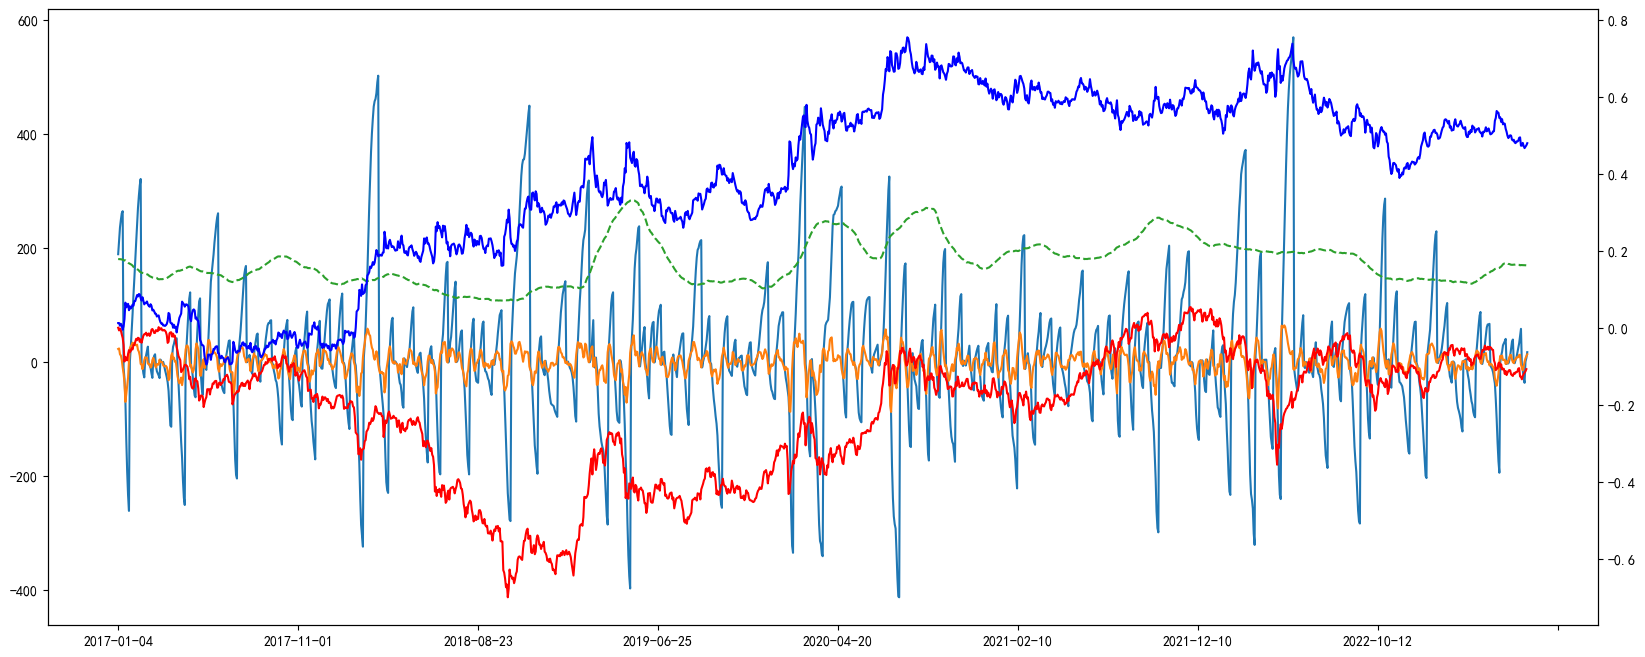

In [2781]:
# (0.1*ATR15[-1000:]).plot()
ss.shift(1).loc[same_dt].loc['2017-01-04':].plot()
# ss.map(lambda x: 800 if x>0 else -800)[-1000:].plot()

GAP.loc[same_dt].loc['2017-01-04':].plot(grid=True)
# ss_cp.map(lambda x: 800 if x>0 else -800)[-1000:].plot()

(TOV250*para).loc[same_dt].loc['2017-01-04':].plot(figsize=(20,8),style='--')
# (TOV250.rolling(20).mean()**(1/3)).loc[same_dt][:2000].plot(figsize=(20,8),style='--',secondary_y=True)
(xy.cl.loc[Index_id,same_dt].loc['2017-01-04':].pct_change().cumsum().dropna()).plot(secondary_y=True,color='red',figsize=(20,8))
# plt.show()
# accumulate_same_sign_elements((xy.cl.loc['300',ATR15.index].pct_change()))[-300:].plot(figsize=(20,8))
(ss.loc[same_dt].map(lambda x:1 if x>0 else -1).shift(1) * (xy.cl.loc[Index_id,same_dt].pct_change().dropna())).loc['2017-01-04':].cumsum().plot(secondary_y=True,color='blue',figsize=(20,8))
# (ss_cp.loc[same_dt].map(lambda x:1 if x>0 else (-1 if x<0 else 0)).shift(1) * (xy.cl.loc['1000',same_dt].pct_change().dropna())).loc['2017-01-04':].cumsum().plot(secondary_y=True,color='blue',figsize=(20,8))

0.037089024735376806


<Axes: >

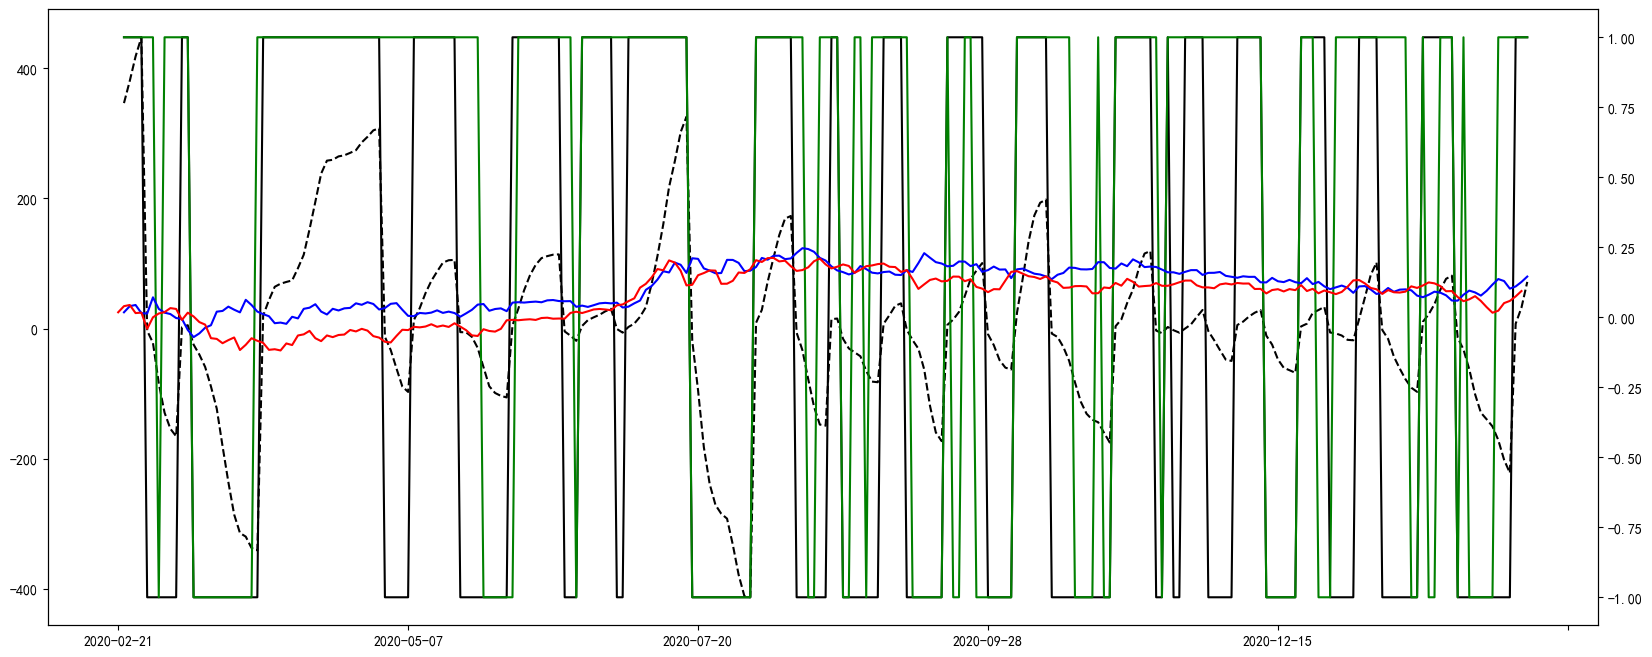

In [2782]:
ss_sigh = ss_cp.copy().ffill()
print(ss_sigh.loc['2020-02-20':'2021-02-20'].shift(1).corr(xy.cl.loc[Index_id,'2020-02-20':'2021-02-20'].pct_change()))
# ss[ss>ATR15]
ss.loc['2020-02-20':'2021-02-20'].shift(1).plot(color='black',style='--',figsize=(20,8))
ss_sigh.loc['2020-02-20':'2021-02-20'].shift(1).plot(color='black',figsize=(20,8),secondary_y=True)
pd.Series(OneTimeDct).loc['2020-02-20':'2021-02-20'].shift(1).plot(color='green',figsize=(20,8),secondary_y=True)
(ss_sigh.loc['2020-02-20':'2021-02-20'].shift(1) * xy.cl.loc[Index_id,'2020-02-20':'2021-02-20'].pct_change()).cumsum().plot(color='blue',figsize=(20,8),secondary_y=True)
# DEA10.loc['300','2020-01-04':'2020-08-15'].plot(color='gray',figsize=(20,8))
(xy.cl.loc['1000','2020-02-20':'2021-02-20'].pct_change().cumsum().dropna()).plot(secondary_y=True,color='red',figsize=(20,8))

In [2783]:
(xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change().cumsum().dropna())

2007-01-05    0.024686
2007-01-08    0.060484
2007-01-09    0.084899
2007-01-10    0.111931
2007-01-11    0.121762
                ...   
2023-07-24    2.236395
2023-07-25    2.252735
2023-07-26    2.246423
2023-07-27    2.238725
2023-07-28    2.247751
Name: 1000, Length: 4028, dtype: float64

0.03193900936668181


<Axes: >

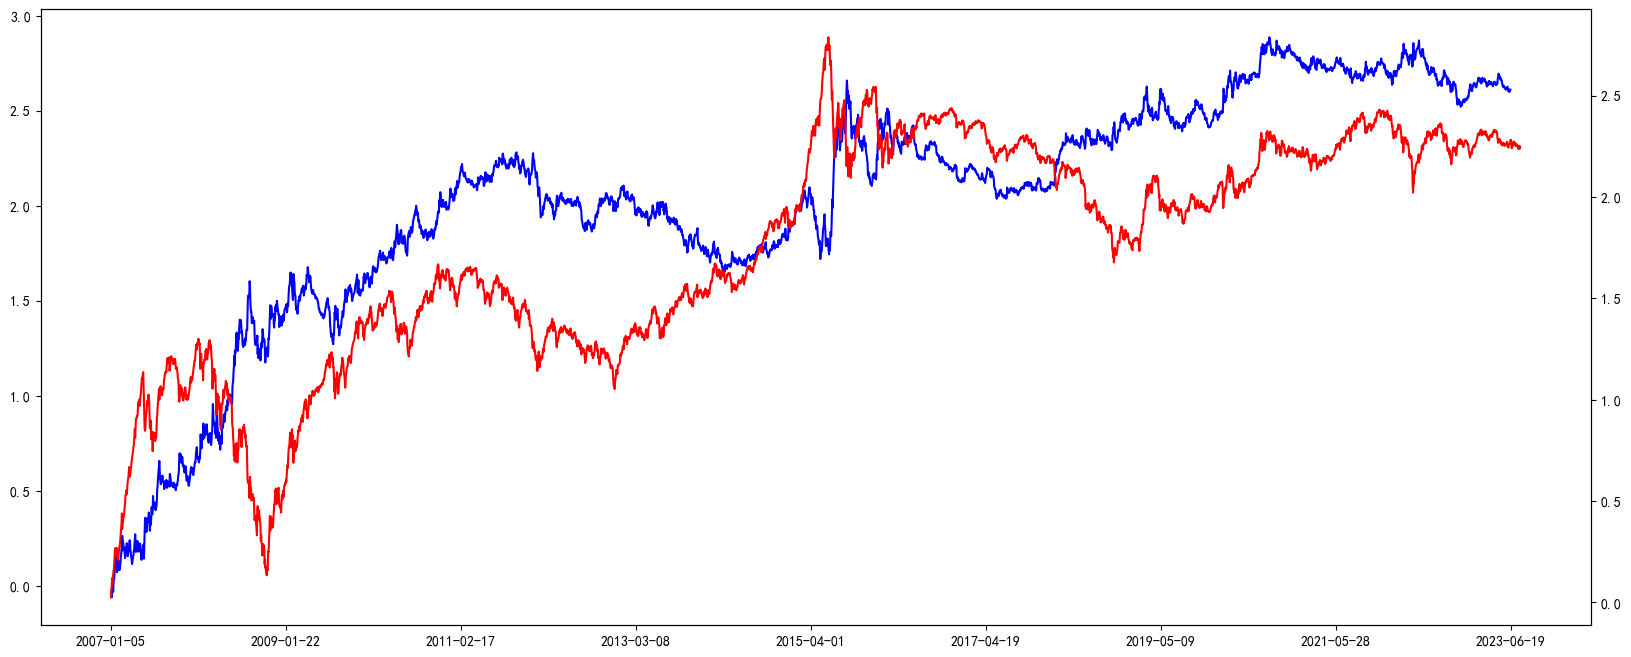

In [2800]:
ss_sigh = ss_cp.copy().ffill()
print(ss_sigh.loc['2007-01-03':'2023-07-30'].shift(1).corr(xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change()))
# ss[ss>ATR15]
# ATR15.loc['2020-02-05':'2020-07-20'].shift(1).plot(color='gray',figsize=(20,8))
(ss_sigh.loc['2007-01-03':'2023-07-30'].shift(1) * xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change()).cumsum().plot(color='blue',figsize=(20,8))
# DEA10.loc['300','2020-01-04':'2020-08-15'].plot(color='gray',figsize=(20,8))
(xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change().cumsum().dropna()).plot(secondary_y=True,color='red',figsize=(20,8))

# ss_sigh.loc['2007-01-03':'2023-07-20'].shift(1).plot(color='black',figsize=(20,8),secondary_y=True)

In [2785]:
def find_hl(ss_sigh):
    # 找出每个波段的高低点
    pre_sig = 0
    sig = {}
    period_extreme_low = {}
    period_extreme_high = {}
    period_flag = {}
    period_price = {}
    period_lenth = {}
    
    for count, (s, _c) in enumerate(zip(ss_sigh, xy.cl.loc['300',:].loc[ss_sigh.index])):

        if count == 0:
            dt = ss_sigh.index[count]
            pre_dt = ss_sigh.index[count]
            pre_sig = s
            sig[dt] = s
            period_flag[dt] = 1
            period_extreme_low[1] = _c
            period_extreme_high[1] = _c
            period_lenth[1] = 1
            period_price[period_flag[dt]] = {dt:_c}
            keep = 0

        else:
            dt = ss_sigh.index[count]
            pre_dt = ss_sigh.index[count-1]
            sig[dt] = s

            # 保持同波段
            if sig[dt] == pre_sig:
                period_flag[dt] = period_flag[pre_dt]
                period_extreme_low[period_flag[dt]] = min(_c, period_extreme_low[period_flag[pre_dt]])
                period_extreme_high[period_flag[dt]] = max(_c, period_extreme_high[period_flag[pre_dt]])
                period_lenth[period_flag[dt]] += 1
                period_price[period_flag[dt]][dt] = _c

            # 切换波段
            else:
                keep = 0
                period_flag[dt] = period_flag[pre_dt] + 1 
                period_extreme_low[period_flag[dt]] = _c
                period_extreme_high[period_flag[dt]] = _c
                period_lenth[period_flag[dt]] = 1
                
                period_price[period_flag[dt]] = {dt:_c}
                
            pre_sig = s

    return period_extreme_low, period_extreme_high, period_price, period_lenth

In [2786]:
import copy

In [2787]:
def cal_PositionEffect(
    period_price,
    period_extreme_low,
    period_extreme_high,
    _sig,
    flag,
    p,
    _date,
    i
):
    global TimeEffect
    global PriceEffect
    flag0 = copy.deepcopy(flag)
    
    
    if flag < 5:
        return None
    
    if _sig > 0:
        while True:
            dist = len(list(period_price[flag-1].values())) - list(period_price[flag-1].values()).index(period_extreme_low[flag-1]) + i # p距离上一个low点的距离
            scale = len(list(period_price[flag-1].values())) - list(period_price[flag-1].values()).index(period_extreme_high[flag-1]) - (dist-i) # 上一个high点距离上一个low点的距离
            if (scale > 0) & (abs(period_extreme_high[flag-1] - period_extreme_low[flag-1]) != 0):
                break
            else:
                flag = flag - 1
                # print(flag)
                continue
        if _date in PriceEffect.keys():
            pass
        else:    
            PriceEffect[_date] = (p - period_extreme_low[flag-1]) / abs(period_extreme_high[flag-1] - period_extreme_low[flag-1])
    else:
        while True:
            dist = len(list(period_price[flag-1].values()))-list(period_price[flag-1].values()).index(period_extreme_high[flag-1]) + i # p距离上一个lhigh点的距离
            scale = len(list(period_price[flag-1].values()))-list(period_price[flag-1].values()).index(period_extreme_low[flag-1]) - (dist-i) # 上一个high点距离上一个low点的距离
            if (scale > 0) &(abs(period_extreme_high[flag-1] - period_extreme_low[flag-1]) != 0):
                break
            else:
                flag = flag - 1
                # print(flag)
                continue
        if _date in PriceEffect.keys():
            pass
        else:
            PriceEffect[_date] = (p - period_extreme_high[flag-1]) / abs(period_extreme_high[flag-1] - period_extreme_low[flag-1])
    
    if _date in TimeEffect.keys():
            pass
    else:    
        TimeEffect[_date] = dist / scale
    

In [2788]:
def loop(ss_sigh_cp,period_extreme_low, period_extreme_high, period_price, period_lenth):
    global GV
    global OneTimeDct
    global LastPrice
    global TimeEffect
    global PriceEffect
    global Times
    # print('-----------------------------')
    sigs = {}
    xx = 0
    flags = ss_sigh_cp[ss_sigh_cp!=ss_sigh_cp.shift(1)].values
    flags_num = len(flags)
    print(flags_num)

    for flag, _sig in enumerate(flags):
        
        flag += 1
        # display(list(period_price[flag].keys())[0],ss_sigh_cp.loc[list(period_price[flag].keys())[0]])
        if flag <= 20:
            sigs.update(ss_sigh_cp.loc[list(period_price[flag].keys())].to_dict())
            OneTimeDct.update(ss_sigh_cp.loc[list(period_price[flag].keys())].to_dict())
            print(flag)
            continue
        else:
            if flag >= flags_num:
                GV = True
            else: pass
                
            for i, p in enumerate(period_price[flag].values()):
                _date = str(list(period_price[flag].keys())[i])[:10]
                # print(_date)
                
                if _date in OneTimeDct.keys():
                    pass
                else:
                    OneTimeDct[_date] = _sig
                
                # 最后一天跳出
                if _date == '2023-06-01':
                    GV = True
                else:
                    pass
                
                # 破低位转向
                if (_sig > 0) & (p < 1.02*period_extreme_low[flag-1]) & (len(period_price[flag-1])>=5):
                    print('lll')
                    
                    OneTimeDct[_date] = -1
                    
                    # 令上一个低点更高
                    ss_sigh_cp.loc[list(period_price[flag].keys())[:i+1]] = -1
                    print('---------------------------')
                    period_extreme_low, period_extreme_high, period_price, period_lenth = find_hl(ss_sigh_cp)
                    # -------------->计算点位效率
                    # cal_PositionEffect(period_price,period_extreme_low,period_extreme_high,_sig,flag,p,_date,i)
                    Times += 1
                    
                    # if Times == 1:
                    #     GV = True
                    #     break 

                    sigs = loop(ss_sigh_cp,period_extreme_low, period_extreme_high, period_price, period_lenth)
                    
                        
                    if GV:
                        return sigs
                    
                
                # 破高位转向
                elif (_sig < 0) & (p > 0.98*period_extreme_high[flag-1]) & (len(period_price[flag-1])>=5):
                    print('hhh')
                    
                    OneTimeDct[_date] = 1
                    ss_sigh_cp.loc[list(period_price[flag].keys())[:i+1]] = 1
                    print('++++++++++++++++++++++++++++')

                    period_extreme_low, period_extreme_high, period_price, period_lenth = find_hl(ss_sigh_cp)
                    # -------------->计算点位效率
                    # cal_PositionEffect(period_price,period_extreme_low,period_extreme_high,_sig,flag,p,_date,i)
                    Times += 1
                    
                    # if Times == 1:
                    #     GV = True
                    #     break 
                        
                    sigs = loop(ss_sigh_cp,period_extreme_low, period_extreme_high, period_price, period_lenth)
                    
                        
                    if GV:
                        return sigs

                else:
                    # cal_PositionEffect(period_price,period_extreme_low,period_extreme_high,_sig,flag,p,_date,i)
                    
                    if GV:
                        sigs[list(period_price[flag].keys())[i]] = _sig
                        return ss_sigh_cp
                        # return sigs
                    else:
                        sigs[list(period_price[flag].keys())[i]] = _sig
                    



In [2789]:
period_extreme_high[3-1]

1378.756

In [2790]:
ss_sigh_cp = ss_sigh.copy()

In [2791]:
period_extreme_low, period_extreme_high, period_price, period_lenth = find_hl(ss_sigh)

In [2792]:
GV = False
global GV

OneTimeDct = {}
global OneTimeDct

LastPrice = 0
global LastPrice

TimeEffect = {}
global TimeEffect

PriceEffect = {}
global PriceEffect

Times = 0
global Times

In [2793]:
try:
    SIGS = loop(ss_sigh_cp,period_extreme_low, period_extreme_high, period_price, period_lenth)
except StopIteration:
    print("停止递归，找到目标值")

705
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
705
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
705
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
705
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
703
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
703
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
703
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
703
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
703
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
703
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
701
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
hhh
++++++++++++++++++++++++++++
701
1
2
3
4
5
6
7
8
9
10
11
12
1

In [2795]:
print(pd.Series(OneTimeDct).loc['2007-01-03':'2023-07-30'].shift(1).corr(xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change()))

0.055568315802636305


In [2796]:
pd.Series(OneTimeDct).ffill()[pd.Series(OneTimeDct).ffill()!=pd.Series(OneTimeDct).ffill().shift()]

2006-05-08    1.0
2006-05-23   -1.0
2006-05-29    1.0
2006-06-07   -1.0
2006-06-19    1.0
             ... 
2023-03-27   -1.0
2023-03-31    1.0
2023-04-21   -1.0
2023-05-08    1.0
2023-05-09   -1.0
Length: 604, dtype: float64

In [2797]:
ss_sigh.ffill()[ss_sigh.ffill()!=ss_sigh.ffill().shift()]

2006-05-08    1.0
2006-05-23   -1.0
2006-05-29    1.0
2006-06-07   -1.0
2006-06-19    1.0
             ... 
2023-05-17    1.0
2023-05-24   -1.0
2023-05-26    1.0
2023-06-06   -1.0
2023-06-12    1.0
Name: 1000, Length: 705, dtype: float64

0.03193900936668181


<Axes: >

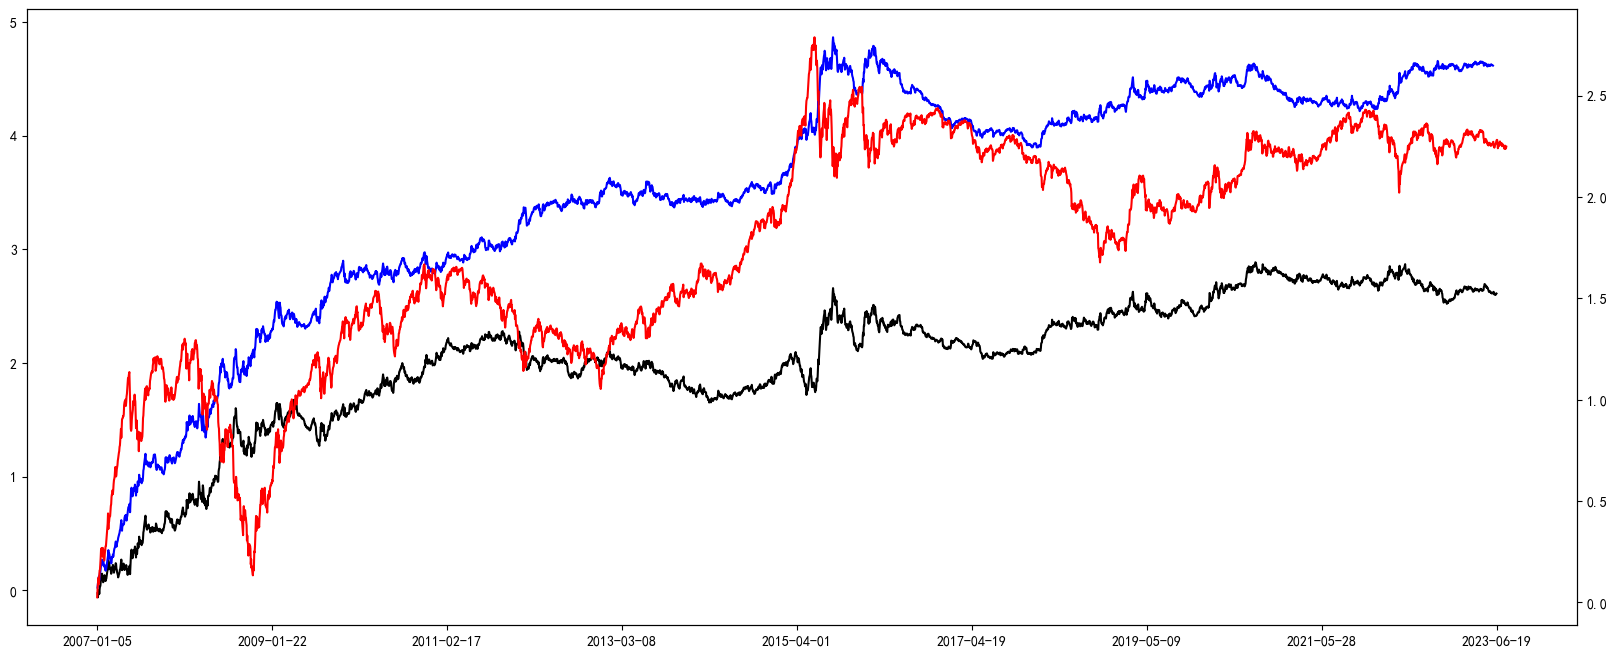

In [2798]:
ss_sigh = ss_cp.copy().ffill()
print(ss_sigh.loc['2007-01-03':'2023-07-30'].shift(1).corr(xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change()))
# ss[ss>ATR15]
# ATR15.loc['2020-02-05':'2020-07-20'].shift(1).plot(color='gray',figsize=(20,8))
(ss_sigh.loc['2007-01-03':'2023-07-30'].shift(1) * xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change()).cumsum().plot(color='black',figsize=(20,8))
(pd.Series(OneTimeDct).loc['2007-01-03':'2023-07-30'].shift(1) * xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change()).cumsum().plot(color='blue',figsize=(20,8))
# DEA10.loc['300','2020-01-04':'2020-08-15'].plot(color='gray',figsize=(20,8))
(xy.cl.loc[Index_id,'2007-01-03':'2023-07-30'].pct_change().cumsum().dropna()).plot(secondary_y=True,color='red',figsize=(20,8))

# ss_sigh.loc['2007-01-03':'2023-07-20'].shift(1).plot(color='black',figsize=(20,8),secondary_y=True)

In [2082]:
SituationRatio = (xy.index_tov.loc[index_name,:].rolling(250).mean() /  xy.cl.loc[index_name,:].pct_change().rolling(250).std()).dropna() 

In [2083]:
MA20 = SituationRatio.rolling(10).mean()
MA60 = SituationRatio.rolling(20).mean()
DIFF = (MA20-MA60)

In [2084]:
_SituationRatio = DIFF.copy()
signal_Sit = pd.Series(np.nan, index = _SituationRatio.index)  
signal_Sit.loc[_SituationRatio[(DIFF>0)].index] = 1
signal_Sit.loc[_SituationRatio[(DIFF<0)].index] = -1

In [2085]:
### 换手/波动 上升期间做多，否则做空

In [2485]:
index_name = '500'

In [2487]:
STD120 = (xy.cl.loc[index_name,:].pct_change().rolling(250).std()).loc['2006-04-30':].dropna()
TOV120 = (xy.index_tov.loc[index_name,:].rolling(250).mean()).loc['2006-04-30':].dropna()

VOL120_diff = (xy.index_volume.loc[index_name,:].rolling(5).mean()).loc['2006-04-30':].dropna() - (xy.index_volume.loc[index_name,:].rolling(20).mean()).loc['2006-04-30':].dropna()

In [2488]:
X = accumulate_same_sign_elements(VOL120_diff).loc['2017-01-07':]

In [2489]:
GAP = (DIFF10.loc[:'2023-06-15'] - DEA10.loc[:'2023-06-15'])
ss = accumulate_same_sign_elements(GAP[same_dt])#, ATR15[same_dt], 0.03)

In [2490]:
std_down_diff = STD120.rolling(5).mean() - STD120.rolling(10).mean()
tov_down_diff = TOV120.rolling(5).mean() - TOV120.rolling(10).mean()
tov_down_diff2 = tov_down_diff.rolling(1).mean() - tov_down_diff.rolling(5).mean()

<Axes: >

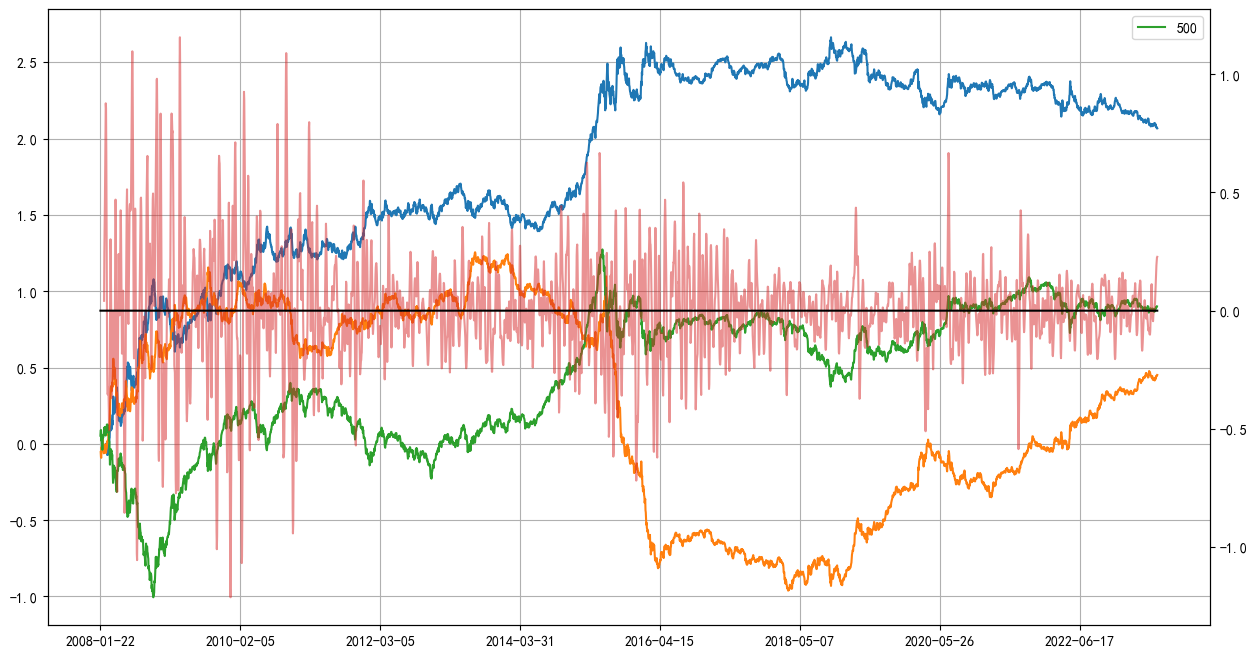

In [2546]:
((signal_Sit.ffill().shift(1)* xy.cl.loc[index_name,signal_Sit.index].pct_change())).loc['2007-01-04':].cumsum().loc[:].plot(figsize=(15,8))
((tov_down_diff2.map(lambda x:1 if x>0 else -1).ffill().shift(1)* xy.cl.loc[index_name,signal_Sit.index].pct_change())).loc['2007-01-04':].cumsum().loc[:].plot(figsize=(15,8))
(xy.cl.loc[index_name,signal_Sit.index].pct_change().loc['2007-01-04':].cumsum().dropna().rename(index_name)).plot(legend=True,grid=True,figsize=(15,8))

(pd.Series(tov_down_diff2,index=signal_Sit.index).loc['2007-01-04':]*(100)).plot(secondary_y=True,alpha=0.5,figsize=(15,8))
pd.Series(0,SituationRatio.index).loc['2007-01-04':].plot(secondary_y=True,color='black',figsize=(15,8))

In [2492]:
# 震荡：波动率下降、抵换手
# 动量：波动率上升、高换手

### 只对高换手、波动率上升阶段使用

In [2493]:
# 15-16换手、成交额异常

In [2503]:
start_date = '2008-01-04'

In [2504]:
BBret = ((signal_Sit.ffill().shift(1) * xy.cl.loc[index_name,signal_Sit.index].pct_change())).loc['2009-04-30':]

<Axes: >

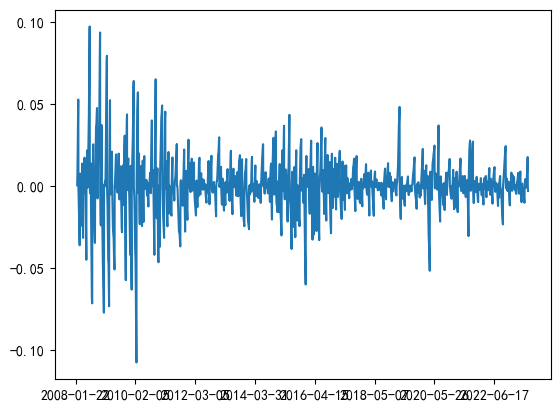

In [ ]:
accumulate_same_sign_elements(tov_down_diff2).plot()

In [2575]:
follow_ret = (ss_sigh.loc['2007-01-03':'2023-07-30'].shift(1) * xy.cl.loc['1000','2007-01-03':'2023-07-30'].pct_change())

In [2579]:
(tov_down_diff2).shift(1)>0.0

2008-01-22    False
2008-01-23    False
2008-01-24    False
2008-01-25    False
2008-01-28    False
              ...  
2023-08-08     True
2023-08-09     True
2023-08-10     True
2023-08-11    False
2023-08-14    False
Name: 500, Length: 3784, dtype: bool

<Axes: >

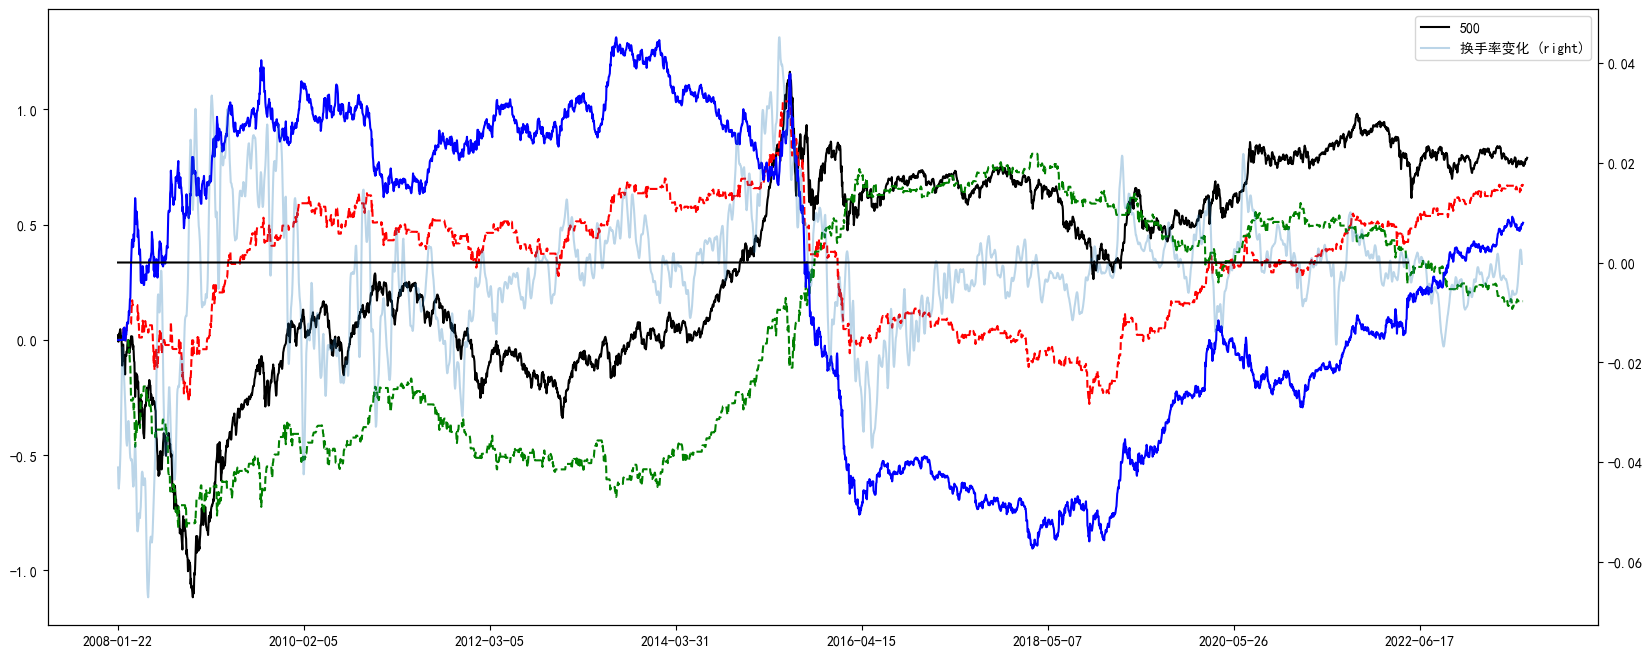

In [2511]:
# TOV120.rolling(1).mean().loc[start_date:].dropna().rename('换手率').plot(legend=True,alpha=0.3,)
# xy.cl.loc['300',:].pct_change().rolling(250).std().loc['2009-04-30':'2023-08-10'].dropna().rename('波动率').plot(legend=True,secondary_y=True,alpha=0.3)
# ((xy.index_tov.loc['300',:].rolling(250).mean()/xy.cl.loc['300',:].pct_change().rolling(250).std())**(1/3)).loc['2006-04-30':].dropna().rename('换手率/波动率').plot(legend=True,alpha=1)
(xy.cl.loc[index_name,start_date:'2023-08-10'].pct_change().cumsum().dropna()).plot(legend=True,color='black',figsize=(20,8))
# DIFF.loc['2006-04-30':].dropna().rolling(20).mean().rename('换手率/波动率').plot(secondary_y=True,legend=True,alpha=1)
# ((std_down_diff).dropna()).rolling(1).sum().loc['2017-01-04':].rename('波动率变化').plot(legend=True,alpha=0.3,secondary_y=True)
((tov_down_diff).dropna()).rolling(1).sum().loc[start_date:].rename('换手率变化').plot(legend=True,alpha=0.3,secondary_y=True)
# tov_down_diff2.loc[start_date:].rename('换手率变化的变化').plot(legend=True,alpha=0.7,secondary_y=True)

ot = pd.Series(OneTimeDct).shift(0)
ret0 = (ss_sigh.loc[start_date:].map(lambda x: 1 if x>0 else (-1 if x<0 else np.nan)).shift(1)).fillna(0) * xy.cl.loc[index_name,:].pct_change().dropna().loc[start_date:]
ret = ((ot.loc[start_date:].map(lambda x: 1 if x>0 else (-1 if x<0 else np.nan)).shift(1)).fillna(0) * xy.cl.loc[index_name,:].pct_change().dropna().loc[start_date:])

pd.Series(0,BBret.loc[start_date:'2023-08-10'].index).plot(color='black',figsize=(20,8),grid=True,alpha=1,secondary_y=True)
# BBret.ffill().loc['2017-01-04':'2023-08-10'].cumsum().plot(color='green',figsize=(20,8),grid=True,alpha=0.5)
long = pd.Series(xy.cl.loc[index_name,signal_Sit.index].pct_change().loc[start_date:][((tov_down_diff**(1)).rolling(1).sum().shift(1) != 0.00) & (accumulate_same_sign_elements(tov_down_diff2).shift(1)>0.0)],index = signal_Sit.loc[start_date:'2023-08-10'].index).loc[start_date:'2023-08-10']
long.fillna(0).cumsum().ffill().plot(color='red',figsize=(20,8),grid=True,style='--')
short = pd.Series(xy.cl.loc[index_name,signal_Sit.index].pct_change().loc[start_date:][((tov_down_diff**(1)).rolling(1).sum().shift(1) != -0.00) & (accumulate_same_sign_elements(tov_down_diff2).shift(1)<-0.0)],index = signal_Sit.loc[start_date:'2023-08-10'].index).loc[start_date:'2023-08-10']
short.fillna(0).cumsum().ffill().plot(color='green',figsize=(20,8),grid=True,style='--')

pd.Series(pd.concat([long.dropna(),-short.dropna()]),index=signal_Sit.index).sort_index().loc[start_date:].fillna(0).cumsum().ffill().plot(color='blue')

In [2508]:
pd.concat([long.dropna(),-short.dropna()]).sort_index().loc['2017-01-04':].fillna(0).cumsum().ffill()

2017-01-04   -0.011693
2017-01-05   -0.012414
2017-01-06   -0.008091
2017-01-09   -0.001216
2017-01-10   -0.004566
                ...   
2023-07-31    1.019946
2023-08-01    1.021693
2023-08-02    1.018182
2023-08-03    1.021674
2023-08-04    1.026572
Name: 500, Length: 1601, dtype: float64

In [2509]:
pd.concat([long.dropna(),-short.dropna()]).sort_index().loc['2017-01-04':].fillna(0).cumsum().ffill()

2017-01-04   -0.011693
2017-01-05   -0.012414
2017-01-06   -0.008091
2017-01-09   -0.001216
2017-01-10   -0.004566
                ...   
2023-07-31    1.019946
2023-08-01    1.021693
2023-08-02    1.018182
2023-08-03    1.021674
2023-08-04    1.026572
Name: 500, Length: 1601, dtype: float64

0.014489315278483517


<Axes: >

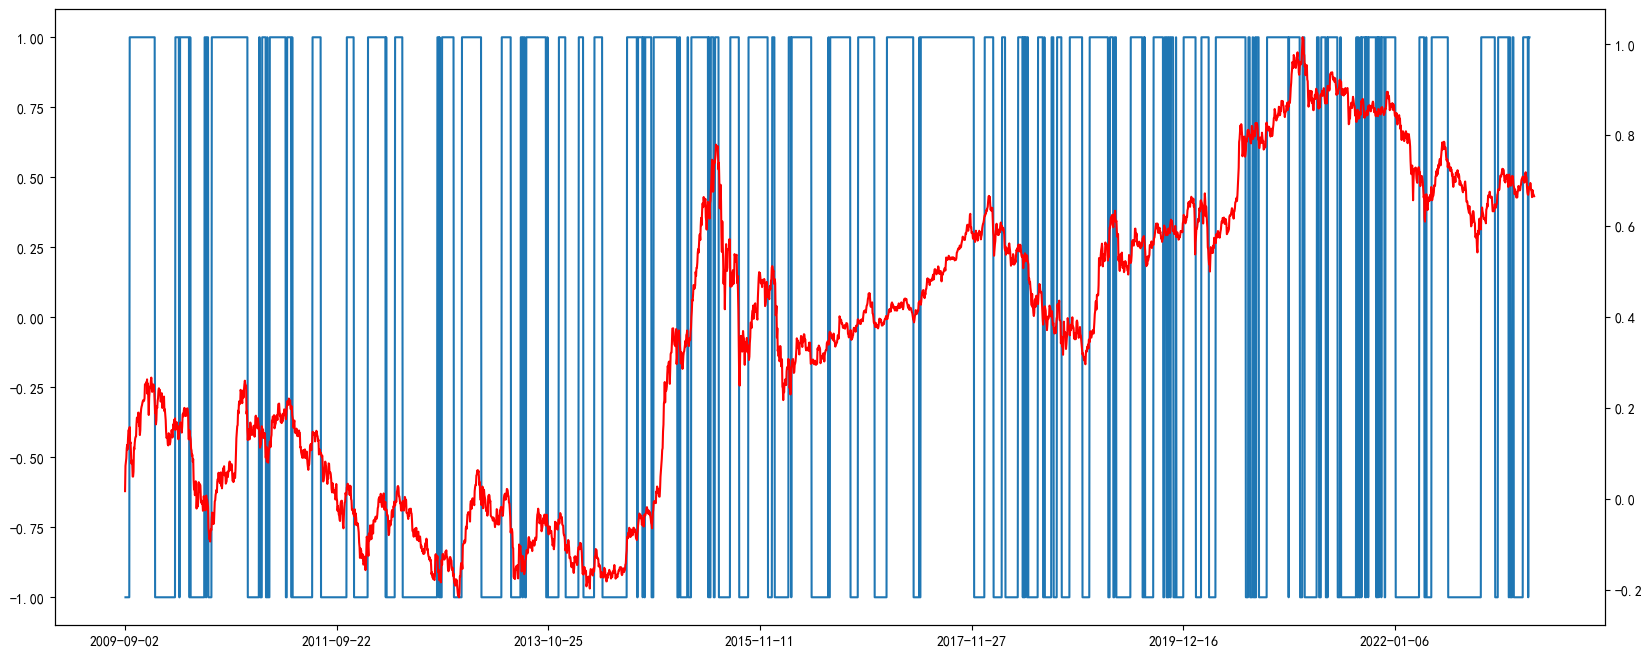

In [2187]:
pd.Series(OneTimeDct).loc['2009-09-01':'2023-05-20'].shift(1).plot()
print(pd.Series(OneTimeDct).loc['2009-09-01':'2023-05-20'].shift(1).corr(xy.cl.loc['300',:].pct_change().dropna()))
(xy.cl.loc['300','2009-09-01':'2023-05-20'].pct_change().cumsum().dropna()).plot(secondary_y=True,color='red',figsize=(20,8))

<Axes: >

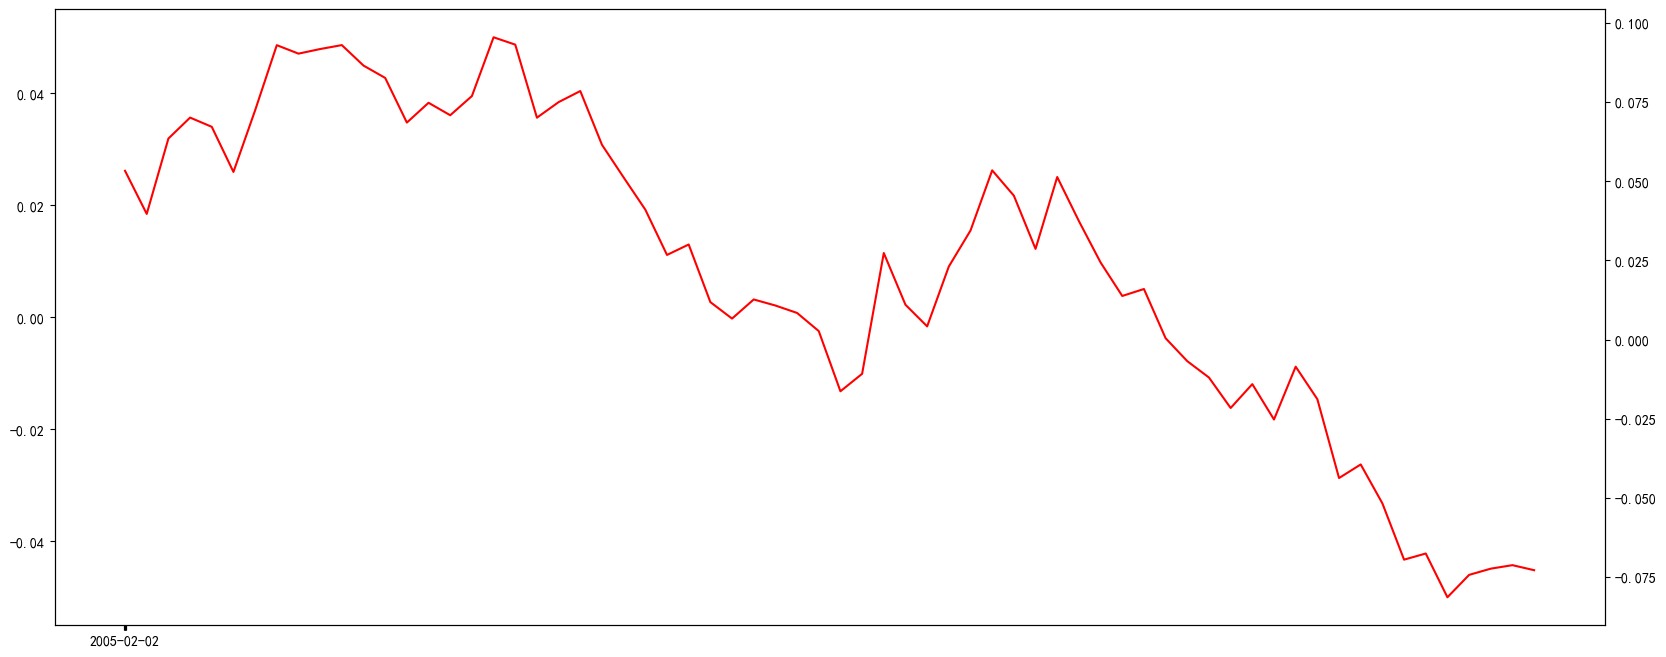

In [2178]:
pd.Series(SIGS).loc['2005-02-01':'2005-05-20'].shift(1).plot()
(xy.cl.loc['300','2005-02-01':'2005-05-20'].pct_change().cumsum().dropna()).plot(secondary_y=True,color='red',figsize=(20,8))

In [2179]:
pd.Series(SIGS).loc['2004-02-20':'2005-05-20'].shift(1).corr(xy.cl.loc['300',:].pct_change().dropna())

nan

In [2180]:
teqt = pd.Series(TimeEffect).shift(0).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).loc[:]
peqt = pd.Series(PriceEffect).shift(0).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).loc[:]

In [2181]:
ot.shift(1).corr(xy.cl.loc['300',:].pct_change().dropna())

0.03306606965225471

<Axes: >

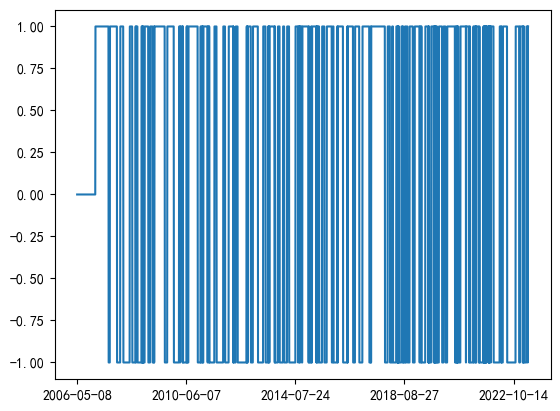

In [2184]:
(ot.loc['2005-03-07':].map(lambda x: 1 if x>0 else (-1 if x<0 else np.nan)).shift(1)).fillna(0).plot()

In [2186]:
ot.loc['2005-03-07':].map(lambda x: 1 if x>0 else (-1 if x<0 else np.nan)).diff().abs().sum()

502.0

<Axes: >

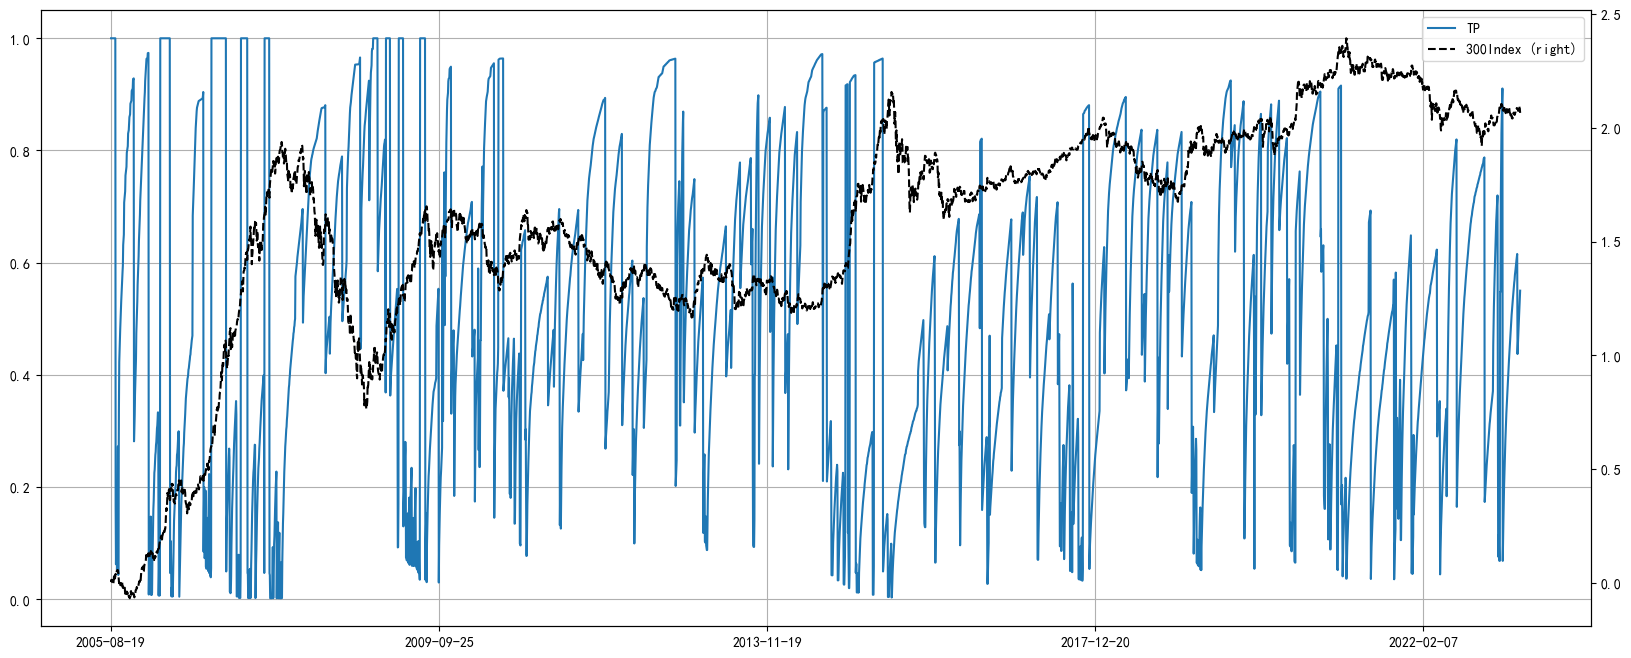

In [3957]:
# pd.Series(OneTimeDct).shift(0).loc['2016-01-07':][:1000].plot(figsize=(20,8),color='yellow')
# ss_sigh.shift(0).loc['2016-01-07':][:1000].plot(figsize=(20,8),color='gray')

# pd.Series(PriceEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(10).mean().loc['2016-01-07':][:2000].rename('PP').plot(figsize=(20,8),legend=True)
# pd.Series(TimeEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(10).mean().loc['2016-01-07':][:2000].rename('TP').plot(figsize=(20,8),legend=True,grid=True)
# np.log(pd.Series(PriceEffect)).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).loc['2005-01-07':][:20000].rename('PP').plot(figsize=(20,8),legend=True)
np.log(pd.Series(TimeEffect)).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).loc['2005-01-07':][:20000].rename('TP').plot(figsize=(20,8),legend=True,grid=True)
# (np.log(pd.Series(PriceEffect)) / np.log(pd.Series(TimeEffect))).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).loc['2005-01-07':][:2000].rename('TP').plot(figsize=(20,8),legend=True,grid=True)

xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].cumsum().loc['2005-01-07':][:20000].rename('300Index').plot(secondary_y=True,color='black',figsize=(20,8),style='--',legend=True)

In [3958]:
peqt = pd.Series(PriceEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(1).mean()
teqt = pd.Series(TimeEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(1).mean()
mixqt = (peqt/teqt)/2

In [3959]:
DATE = '2015-01-07'

In [3960]:
step_wid = 5

In [3961]:
peqt.loc[DATE:].shift(1).rolling(1).mean()[::step_wid].diff().corr(xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:][::step_wid])

-0.0345132038386247

In [3962]:
teqt.loc[DATE:].shift(1).rolling(1).mean()[::step_wid].diff().corr(xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:][::step_wid])

0.02529206223928302

<Axes: >

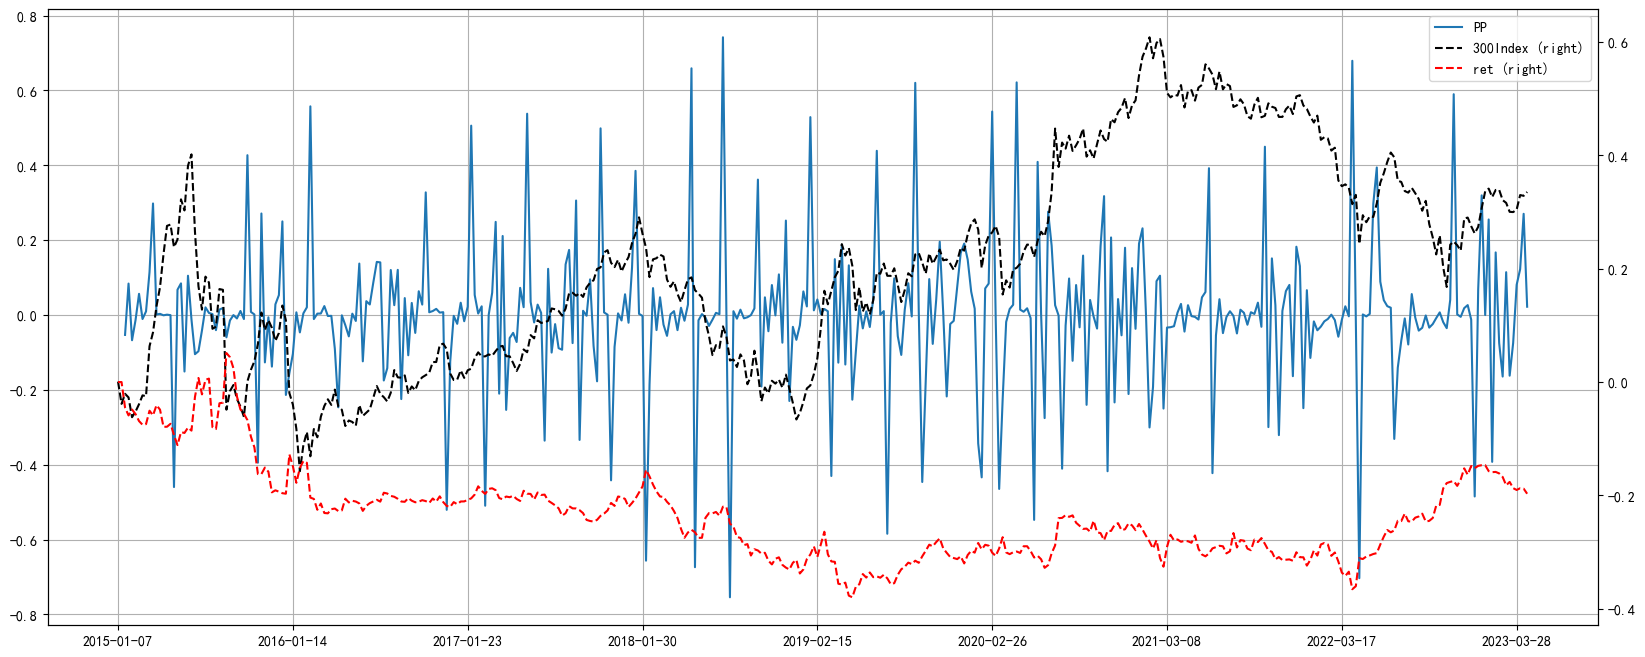

In [3963]:
# pd.Series(OneTimeDct).shift(1).loc[pd.Series(PriceEffect).index].loc[DATE:].plot(figsize=(20,8),color='red',alpha=0.3)

(peqt.loc[DATE:].shift(1).rolling(1).mean()[::step_wid].diff()).rename('PP').plot(figsize=(20,8),legend=True,grid=True)
# teqt.loc[DATE:].rename('TP').plot(figsize=(20,8),legend=True)
# (pd.Series(OneTimeDct).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc[DATE:].cumsum().rename('DNM_adj').plot(secondary_y=True,figsize=(20,8),legend=True)
# ((peqt.loc[DATE:].map(lambda x: 1 if x>0.5 else (-1 if x<0.5 else np.nan)).shift(1)).ffill() * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:]).cumsum().rename('peqt_ret').plot(secondary_y=True,figsize=(20,8),legend=True)
# ((teqt.loc[DATE:].map(lambda x: 1 if x>0.5 else (-1 if x<0.5 else np.nan)).shift(1)).ffill() * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:]).cumsum().rename('teqt_ret').plot(secondary_y=True,figsize=(20,8),legend=True)
# ((mixqt.loc[DATE:].map(lambda x: 1 if x>0.5 else (-1 if x<0.5 else np.nan)).shift(1)).ffill() * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:]).cumsum().rename('mixqt_ret').plot(secondary_y=True,figsize=(20,8),legend=True)
weekly_sig_ret = xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:][::step_wid]
xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:].cumsum()[::step_wid].rename('300Index').plot(secondary_y=True,color='black',figsize=(20,8),style='--',legend=True)
((peqt.loc[DATE:].shift(1).rolling(1).mean()[::step_wid].diff()).map(lambda x: -1 if x < 0 else (1 if x > 0 else np.nan)).fillna(0) * weekly_sig_ret).cumsum().rename('ret').plot(secondary_y=True,color='red',figsize=(20,8),style='--',legend=True)

<Axes: >

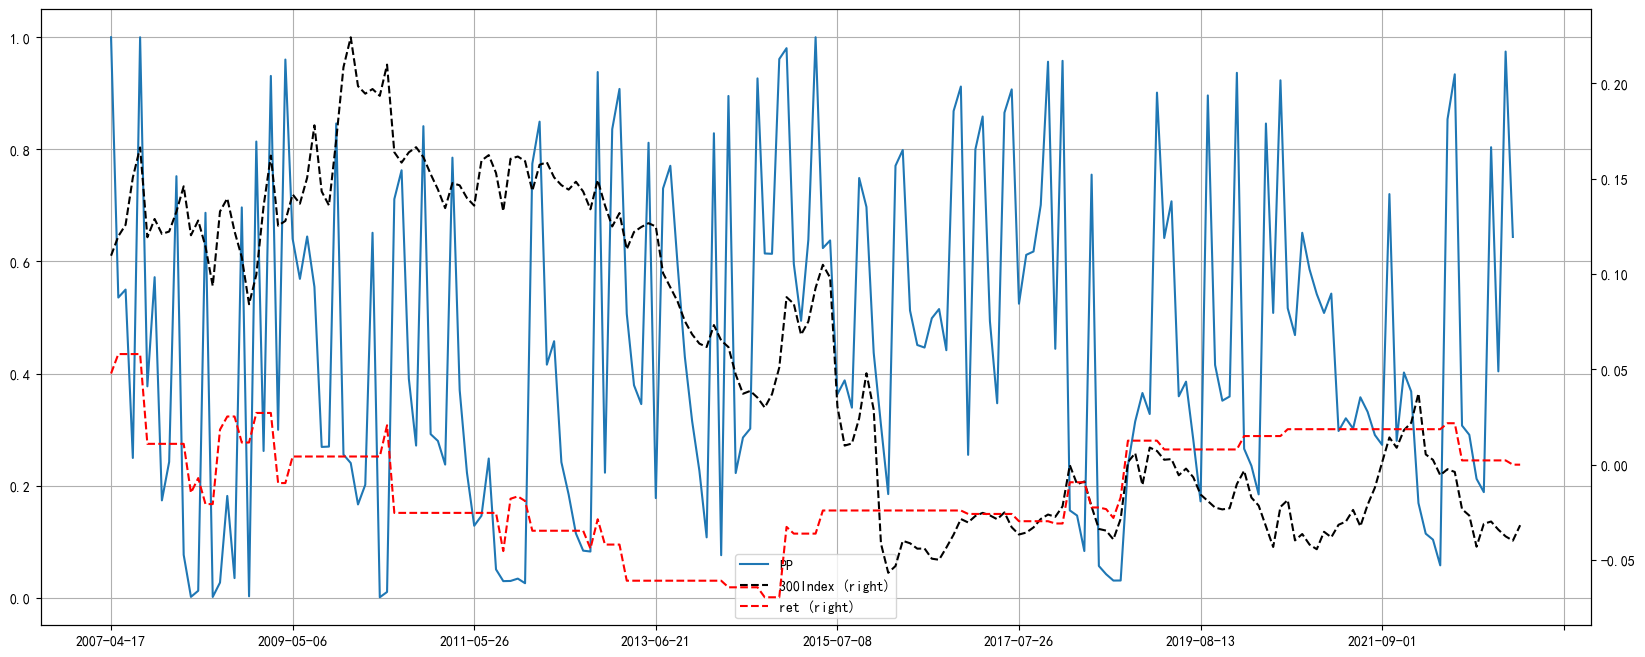

In [3964]:
weekly_sig = peqt.rolling(1).mean()[-8000:][::20].rename('PP').shift(1)
weekly_sig[20:].shift(-1).plot(figsize=(20,8),legend=True,grid=True)
weekly_sig_ret = xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[peqt.rolling(1).mean()[-8000:][::20].index]
weekly_sig_ret.cumsum()[20:].rename('300Index').plot(secondary_y=True,color='black',figsize=(20,8),style='--',legend=True)
(weekly_sig.map(lambda x: 1 if x < 0.1 else (1 if x > 0.9 else np.nan)).fillna(0) * weekly_sig_ret).cumsum()[20:].rename('ret').plot(secondary_y=True,color='red',figsize=(20,8),style='--',legend=True)

In [3965]:
R = (weekly_sig.map(lambda x: -1 if x < 0.1 else (1 if x > 0.9 else np.nan)).fillna(0) * weekly_sig_ret)

In [3966]:
xy.cal_downdraw(ret.dropna())

0.4891960846093564

In [3967]:
(ret.dropna().sum())/len(ret.dropna())*250

0.18353842199452367

In [3968]:
ret.dropna()[ret.dropna()>0].count() / ret[ret!=0].dropna().shape[0]

0.513268156424581

In [3970]:
ret.dropna()[ret.dropna()>0].sum() / ret.dropna()[ret<0].dropna().sum()

-1.1371488429221834

<Axes: >

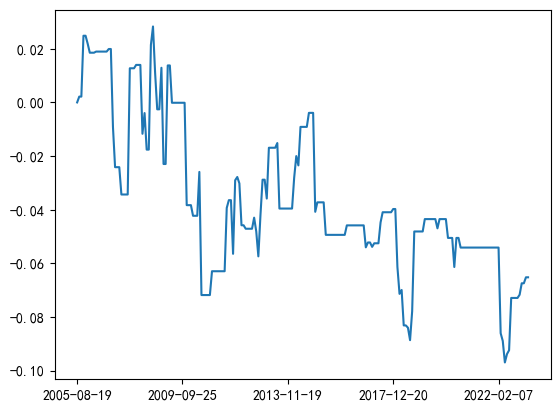

In [3971]:
(weekly_sig.map(lambda x: 1 if x < 0.2 else (-1 if x > 0.8 else np.nan)) * weekly_sig_ret).fillna(0).cumsum().plot()

In [2074]:
weekly_sig_ret

2017-03-31    0.005612
2017-04-11    0.003477
2017-04-18   -0.004942
2017-04-25    0.002831
2017-05-03   -0.003925
                ...   
2023-04-25   -0.005016
2023-05-05   -0.003317
2023-05-12   -0.013256
2023-05-19   -0.002914
2023-05-26    0.000117
Name: 300, Length: 300, dtype: float64

<Axes: >

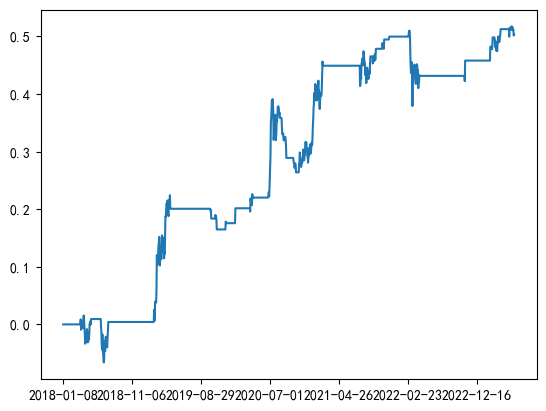

In [2036]:
peqt = pd.Series(PriceEffect).rolling(120,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(1).mean()

sig = peqt.loc[DATE:].map(lambda x:0 if x<=0.15 else (1 if x>=0.8 else np.nan)).shift(1)
sig_df = pd.concat([sig, peqt.loc[DATE:]],axis=1)
sig_df0 = sig_df.copy()

ret_with_fee0 = (sig_df0[0] * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:] - (sig_df0[0].loc[DATE:]).diff().abs() * 0.0005).fillna(0)
ret_with_fee0.cumsum().plot()

In [2037]:
ret_with_fee0.cumsum()[-1]

0.5037788278993759

In [2038]:
xy.cal_downdraw(ret_with_fee0.dropna())

0.1307194547109688

In [2039]:
(ret_with_fee0.dropna().sum())/len(ret_with_fee0.dropna())*250

0.0961409976907206

In [2052]:
ret_with_fee0.dropna()[ret_with_fee0.dropna()>0].count() / ret_with_fee0[ret_with_fee0!=0].dropna().shape[0]

0.5138121546961326

In [2053]:
ret_with_fee0.dropna()[ret_with_fee0.dropna()>0].sum() / ret_with_fee0.dropna()[ret_with_fee0<0].dropna().sum()

-1.3159424554868953

In [2044]:
pre_side = np.nan
long_dates = []
short_dates = []
for _d, _row in sig_df.iterrows():
    # print(pre_side,_row.方向,_row['P/C240日百分位'])
    # print(_d, _row[0], pre_side, _row[1])
    if np.isnan(_row[0]) & (pre_side>0) & (_row[1]>=0.8):
        # print(_d)
        long_dates.append(_d)
        pre_side = _row[0]

    elif np.isnan(_row[0]) & (pre_side<0) & (_row[1]<=(1-0.8)):
        short_dates.append(_d)
        pre_side = _row[0]
        
    else:
        pre_side = _row[0]
        continue

sig_df.loc[long_dates,0] = 1
sig_df.loc[short_dates,0] = 0
sig_df = sig_df.fillna(0)

In [2045]:
ret_with_fee = (sig_df[0] * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc[DATE:] - (sig_df[0].loc[DATE:]).diff().abs() * 0.0005)

In [2046]:
ret_with_fee.cumsum()[-1]

0.44853457667212526

<Axes: >

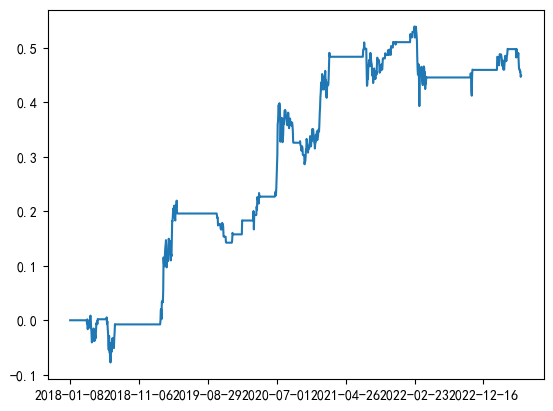

In [2047]:
ret_with_fee.cumsum().plot()

In [2019]:
xy.cal_downdraw(ret_with_fee.dropna())

0.15013279252879758

In [2020]:
(ret_with_fee.dropna().sum())/len(ret_with_fee.dropna())*250

0.09739175989046867

<Axes: >

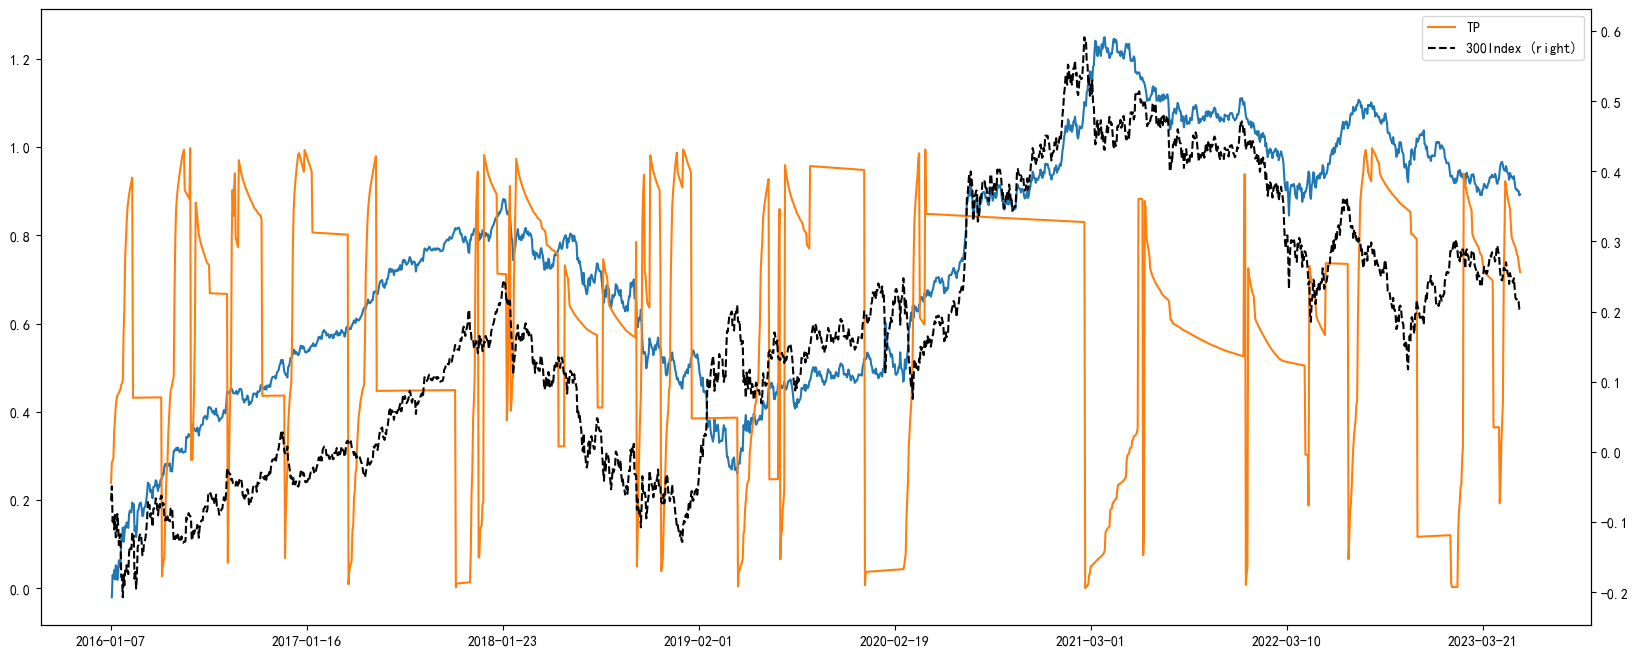

In [1317]:
# ((peqt.loc['2016-01-07':].map(lambda x: 1 if x>0.5 else (-1 if x<0.5 else np.nan)).shift(1)).ffill() * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc['2016-01-07':]).cumsum().plot(figsize=(20,8))
((teqt.loc['2016-01-07':].map(lambda x: 1 if x>0.6 else (-1 if x<0.4 else np.nan)).shift(1)).ffill() * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc['2016-01-07':]).cumsum().plot(figsize=(20,8))
pd.Series(TimeEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(1).mean().loc['2016-01-07':].rename('TP').plot(figsize=(20,8),legend=True)
xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc['2016-01-07':].cumsum().rename('300Index').plot(secondary_y=True,color='black',figsize=(20,8),style='--',legend=True)

<Axes: >

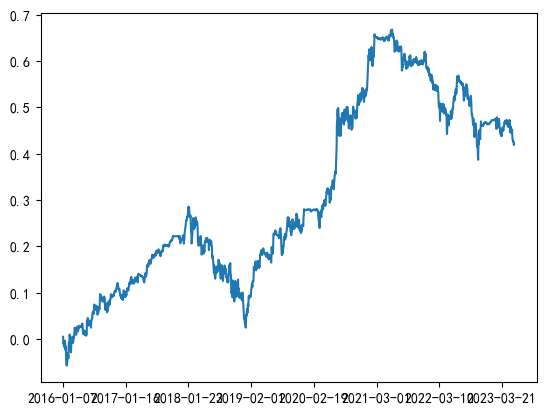

In [ ]:
(pd.Series(TimeEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).rolling(1).mean().loc['2016-01-07':].shift(1) * xy.cl.loc['300',:].pct_change().dropna().loc[pd.Series(PriceEffect).index].loc['2016-01-07':]).cumsum().plot()

<Axes: >

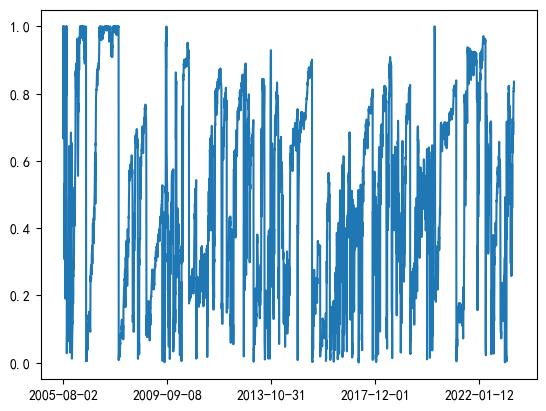

In [1204]:
pd.Series(PriceEffect).rolling(5000,min_periods=1).apply(lambda x:x.rank()[-1]/len(x)).plot(figsize=(20,8))

In [1053]:
pd_OneTimeDct = pd.Series(OneTimeDct)
pd_ss = pd.Series(ss_sigh)
new_OneTimeDct = {}

Except = pd.Series(-1,pd_ss[(pd_OneTimeDct!=pd_ss)].index)
Except = pd.Series(Except,pd_ss.index).fillna(1)

new_OneTimeDct = {}

In [1054]:
Except[Except==-1]

2005-03-08   -1.0
2005-09-08   -1.0
2005-09-13   -1.0
2005-09-14   -1.0
2005-09-19   -1.0
             ... 
2023-01-09   -1.0
2023-01-10   -1.0
2023-01-12   -1.0
2023-01-13   -1.0
2023-01-16   -1.0
Length: 265, dtype: float64

In [1055]:
def find_pre_high_low(dt,ps):   
    for k,v in ps.items():
        if dt in v:
            break
        else:
            high = pd.Series(v).max()
            low = pd.Series(v).min()
    
    return high, low
    

In [1056]:
for r in tqdm(range(diff.shape[0])):
    dt = str(Except.index[r])
    
    if dt in period_price[1].keys():
        continue
    
    pre_hp, pre_lp = find_pre_high_low(dt,period_price)
    # 上一个点有异常
    if Except.shift(1)[r] == -1:
        # 未破
        if (pd_ss[r] != pd_ss.shift(1)[r]) | ((pd_ss[r] == 1) & (xy.cl.loc['300',dt] >= pre_hp)) | ((pd_ss[r] == -1) & (xy.cl.loc['300',dt] <= pre_lp)):
            continue
        else:
            Except.loc[dt] = -1

100%|██████████████████████████████████████████████████████████████████████████████| 4474/4474 [01:09<00:00, 63.97it/s]


In [2391]:
(pd_OneTimeDct).loc['2023-01-20':'2023-07-20'].shift(1).corr(xy.cl.loc['300','2023-01-20':'2023-07-20'].pct_change().dropna())

-0.09188239874351765

<Axes: >

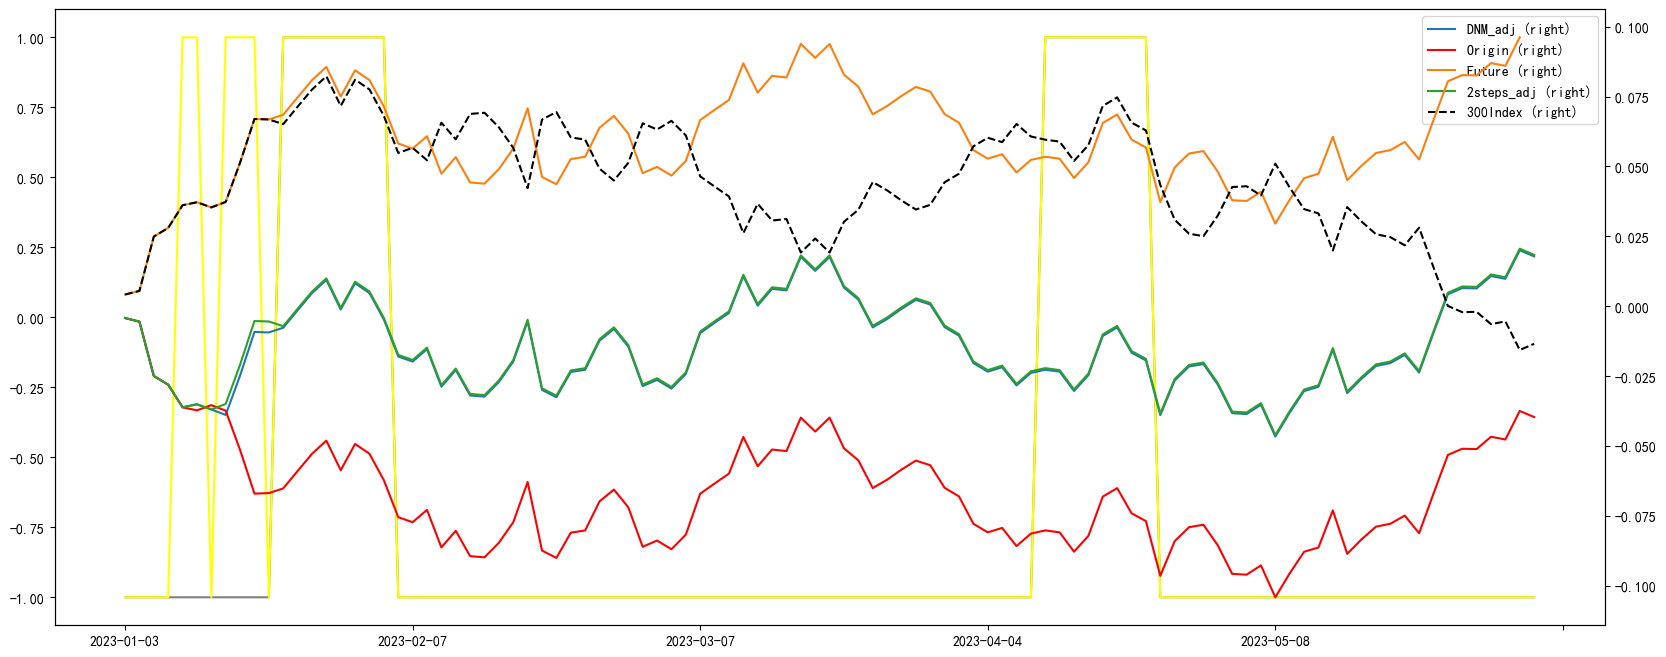

In [2403]:
ss_sigh.loc['2023-01-01':'2023-10-20'].shift(0).plot(color='gray',figsize=(20,8))
pd.Series(OneTimeDct).shift(0).loc['2023-01-01':'2023-10-20'].plot(figsize=(20,8),color='yellow')

(pd.Series(OneTimeDct).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc['2023-01-01':'2023-10-20'].cumsum().rename('DNM_adj').plot(secondary_y=True,figsize=(20,8),legend=True)
(ss_sigh.shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc['2023-01-01':'2023-10-20'].cumsum().rename('Origin').plot(secondary_y=True,color='red',figsize=(20,8),legend=True)
(pd.Series(SIGS).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc['2023-01-01':'2023-10-20'].cumsum().rename('Future').plot(secondary_y=True,figsize=(20,8),legend=True)
(pd.Series((Except*pd.Series(ss_sigh))).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc['2023-01-01':'2023-10-20'].cumsum().rename('2steps_adj').plot(secondary_y=True,figsize=(20,8),legend=True)

xy.cl.loc['300',:].pct_change().dropna().loc['2023-01-01':'2023-10-20'].cumsum().rename('300Index').plot(secondary_y=True,color='black',figsize=(20,8),style='--',legend=True)

In [1017]:
new_period_extreme_low, new_period_extreme_high, new_period_price, new_period_lenth = find_hl(pd.Series(SIGS)[:])

In [1022]:
(pd.Series(OneTimeDct).loc['2016-01-04':].diff()!=0).sum()

111

In [943]:
c = (pd.Series(OneTimeDct).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc['2016-01-04':]

In [944]:
c[c>0].count()/c.count()

0.5110987791342952

<Axes: >

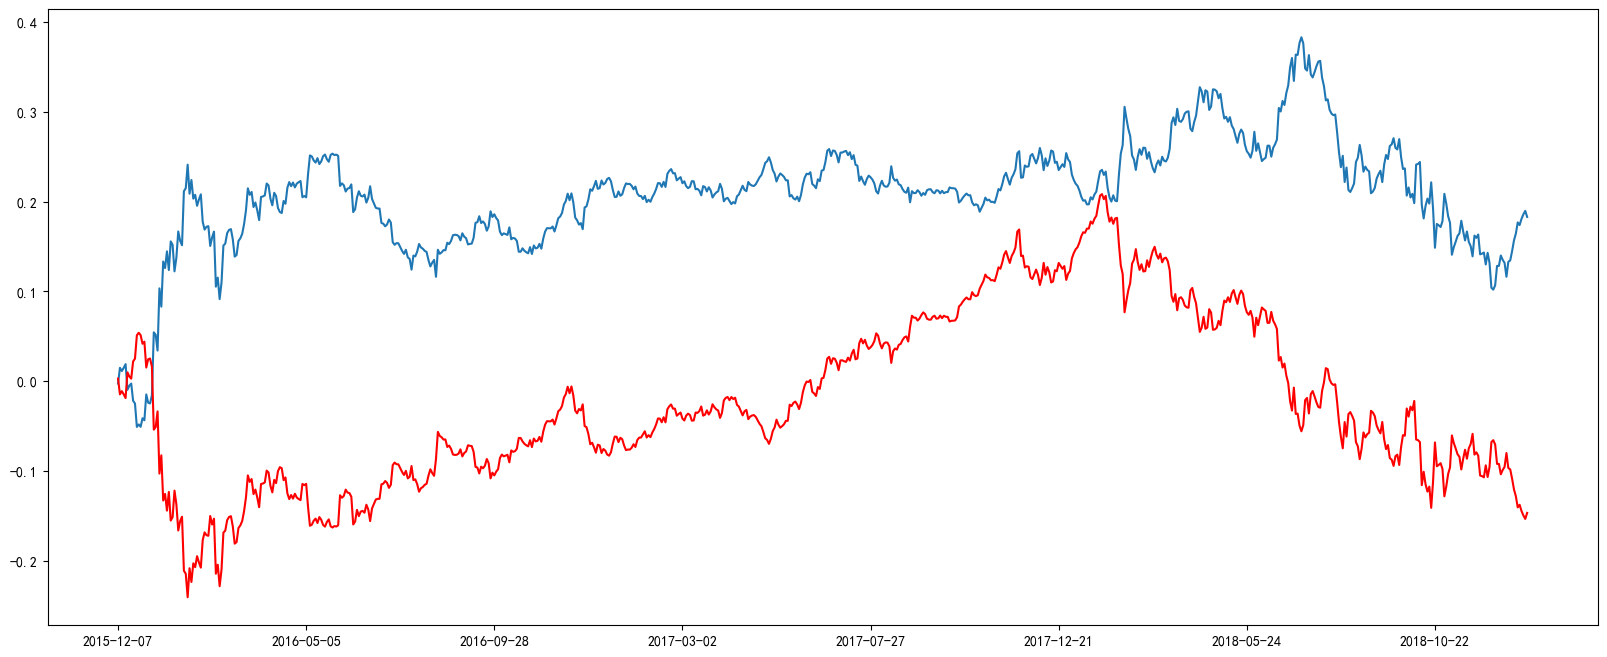

In [2400]:
(pd.Series(OneTimeDct).loc['2015-12-04':'2018-12-31'].shift(1) * xy.cl.loc['300',:].loc['2015-12-04':'2018-12-31'].pct_change()).dropna().cumsum().plot(figsize=(20,8))
(xy.cl.loc['300','2015-12-04':'2018-12-31'].pct_change().dropna().cumsum()).plot(color='red',figsize=(20,8))
# pd.Series(OneTimeDct).shift(1).loc['2022-12-04':'2023-10-20'].plot(figsize=(20,8),color='yellow')

In [422]:
new_period_price

{1: {'2004-12-31': 1000.0,
  '2005-01-04': 982.794,
  '2005-01-05': 992.564,
  '2005-01-06': 983.174,
  '2005-01-07': 983.958,
  '2005-01-10': 993.879,
  '2005-01-11': 997.135,
  '2005-01-12': 996.748},
 2: {'2005-01-13': 996.877},
 3: {'2005-01-14': 988.306,
  '2005-01-17': 967.452,
  '2005-01-18': 974.689,
  '2005-01-19': 967.21,
  '2005-01-20': 956.245,
  '2005-01-21': 982.604,
  '2005-01-24': 998.133},
 4: {'2005-01-25': 997.775, '2005-01-26': 989.928, '2005-01-27': 974.631},
 5: {'2005-01-28': 969.209, '2005-01-31': 954.879, '2005-02-01': 955.951},
 6: {'2005-02-02': 1006.913,
  '2005-02-03': 993.215,
  '2005-02-04': 1016.858,
  '2005-02-16': 1023.584,
  '2005-02-17': 1020.606,
  '2005-02-18': 1006.055,
  '2005-02-21': 1025.633,
  '2005-02-22': 1046.744,
  '2005-02-23': 1043.944,
  '2005-02-24': 1045.46,
  '2005-02-25': 1046.761,
  '2005-02-28': 1039.989,
  '2005-03-01': 1035.934,
  '2005-03-02': 1021.32,
  '2005-03-03': 1027.71},
 7: {'2005-03-04': 1023.667, '2005-03-07': 1029.87

<Axes: >

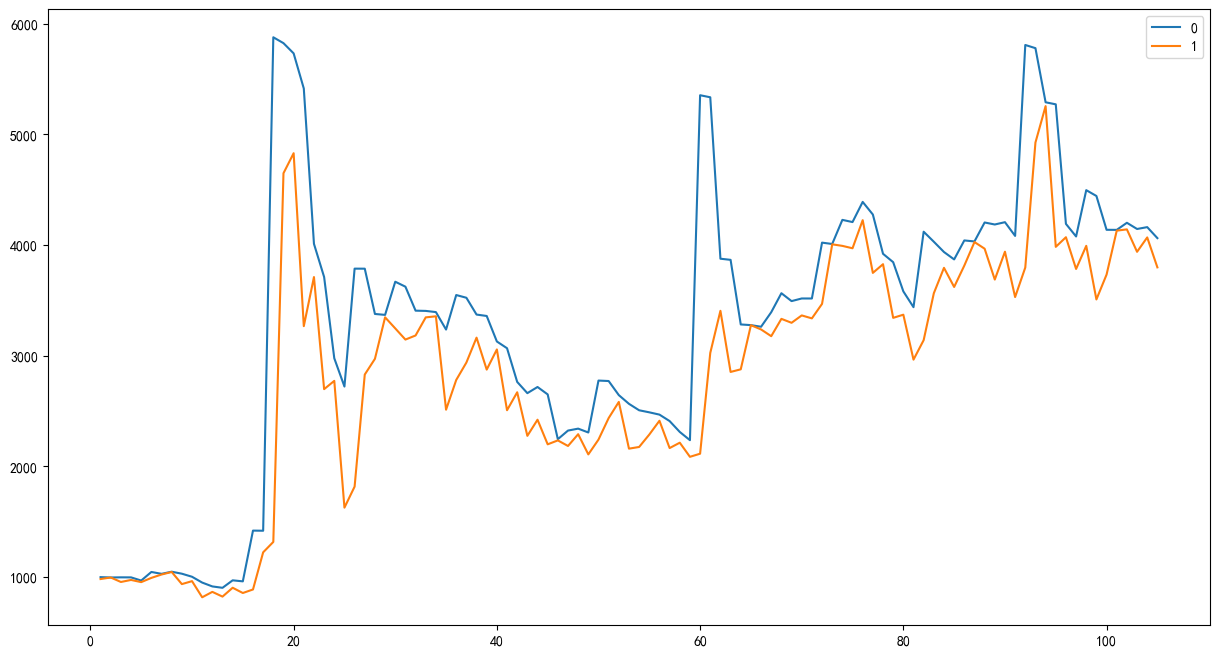

In [400]:
pd.concat([
    pd.Series(new_period_extreme_high),
    pd.Series(new_period_extreme_low)
],axis=1).plot(figsize=(15,8))


<Axes: >

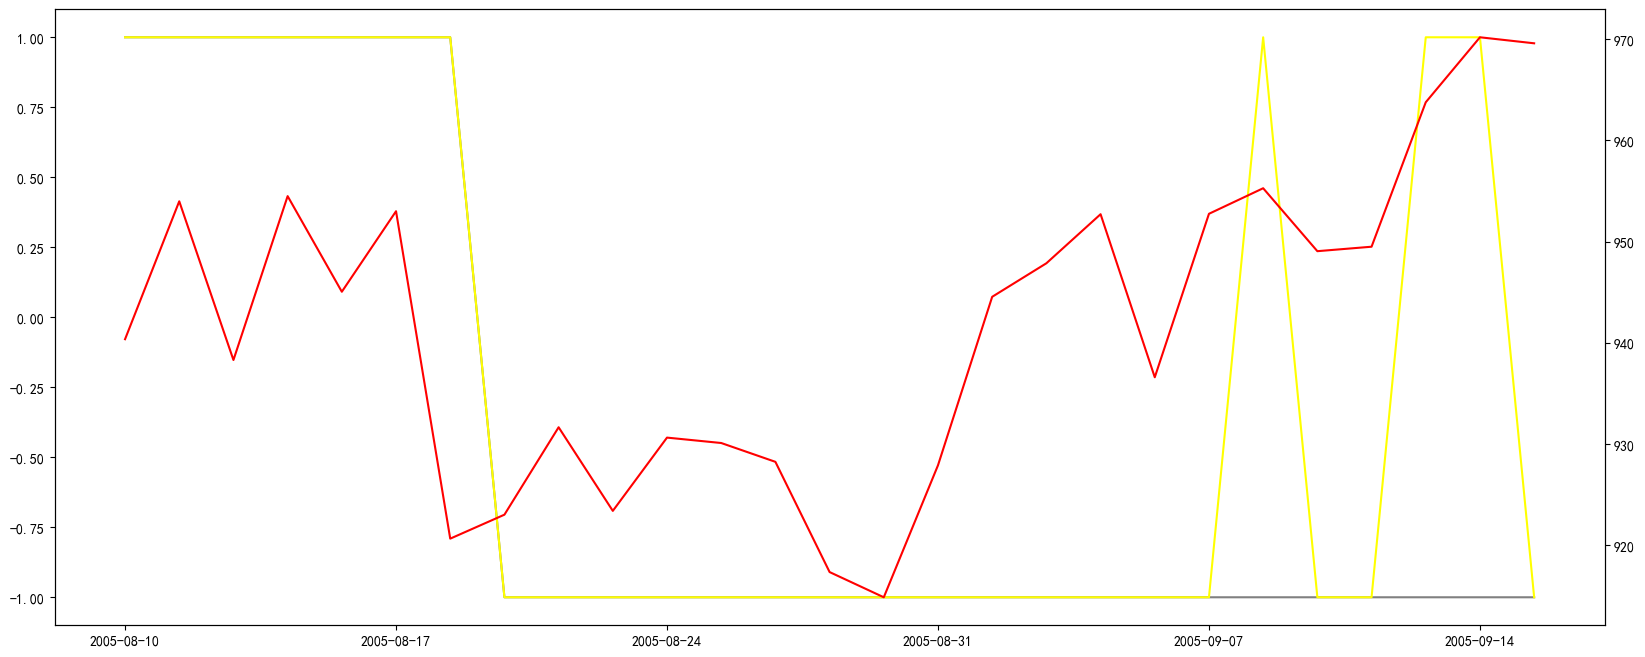

In [645]:
pd.Series(ss_sigh)['2005-08-10':'2005-09-15'].plot(color='gray',figsize=(20,8))
pd.Series(OneTimeDct).loc['2005-08-10':'2005-09-15'].plot(figsize=(20,8),color='yellow')
(xy.cl.loc['300','2005-08-10':'2005-09-15']).plot(secondary_y=True,color='red',figsize=(20,8))

<Axes: >

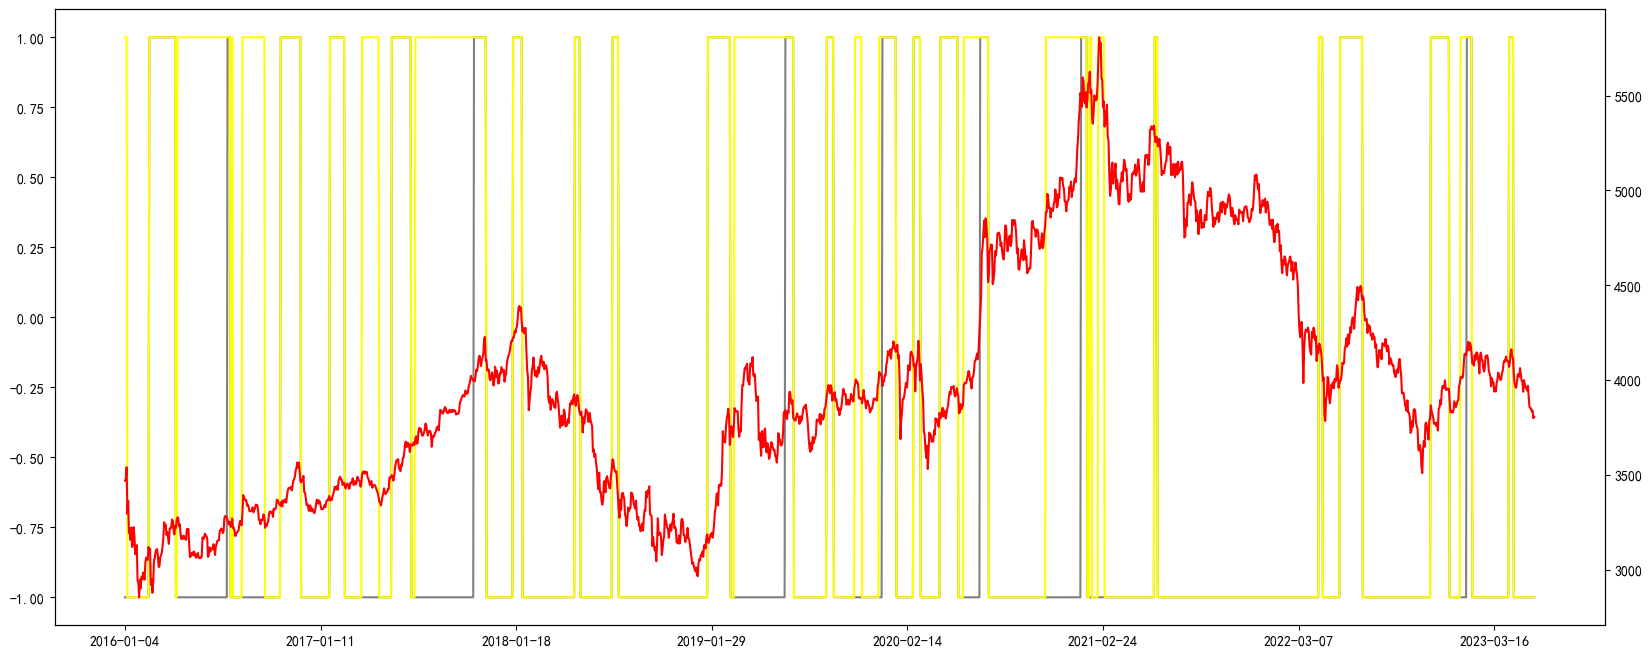

In [935]:
pd.Series(ss_sigh)['2016-01-03':'2023-07-30'].plot(color='gray',figsize=(20,8))
pd.Series((Except*pd.Series(ss_sigh))).loc['2016-01-03':'2023-07-30'].plot(figsize=(20,8),color='yellow')
(xy.cl.loc['300','2016-01-03':'2023-07-30']).plot(secondary_y=True,color='red',figsize=(20,8))

# .loc['2019-01-03':'2021-07-03']

<Axes: >

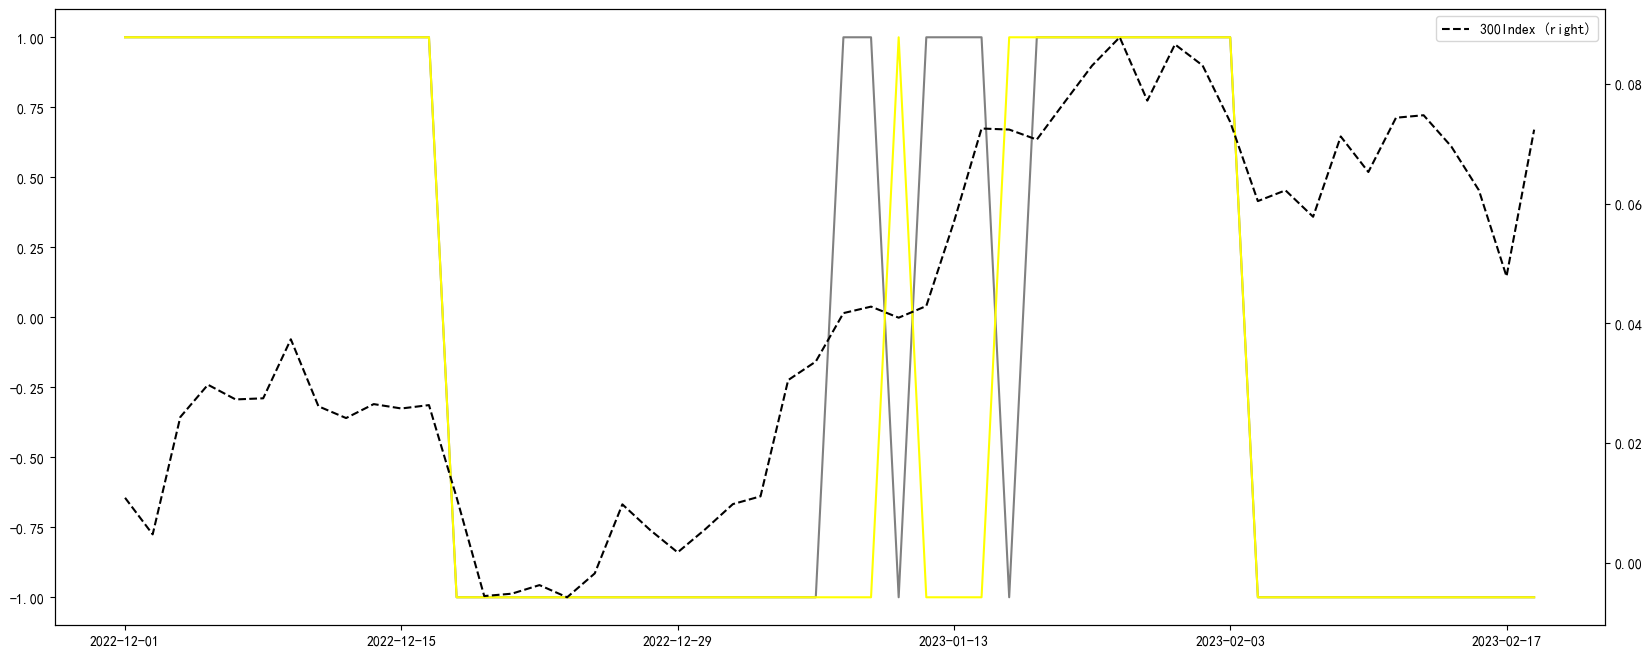

In [1068]:
pd.Series(OneTimeDct).loc['2022-12-01':'2023-02-20'].plot(color='gray',figsize=(20,8))
pd.Series((Except*pd.Series(OneTimeDct))).loc['2022-12-01':'2023-02-20'].plot(figsize=(20,8),color='yellow')
xy.cl.loc['300',:].pct_change().dropna().loc['2022-12-01':'2023-02-20'].cumsum().rename('300Index').plot(secondary_y=True,color='black',figsize=(20,8),style='--',legend=True)

In [758]:
(ss_sigh).loc['2004-01-20':'2023-07-20'].shift(1).corr(xy.cl.loc['300',:].pct_change().dropna())

0.04026372496258871

In [769]:
(pd.Series((Except*ss_sigh)).loc['2005-01-04':].diff()!=0).sum()*2*0.001

0.318

In [ ]:
.loc['2022-01-01':'2023-10-20']

<Axes: >

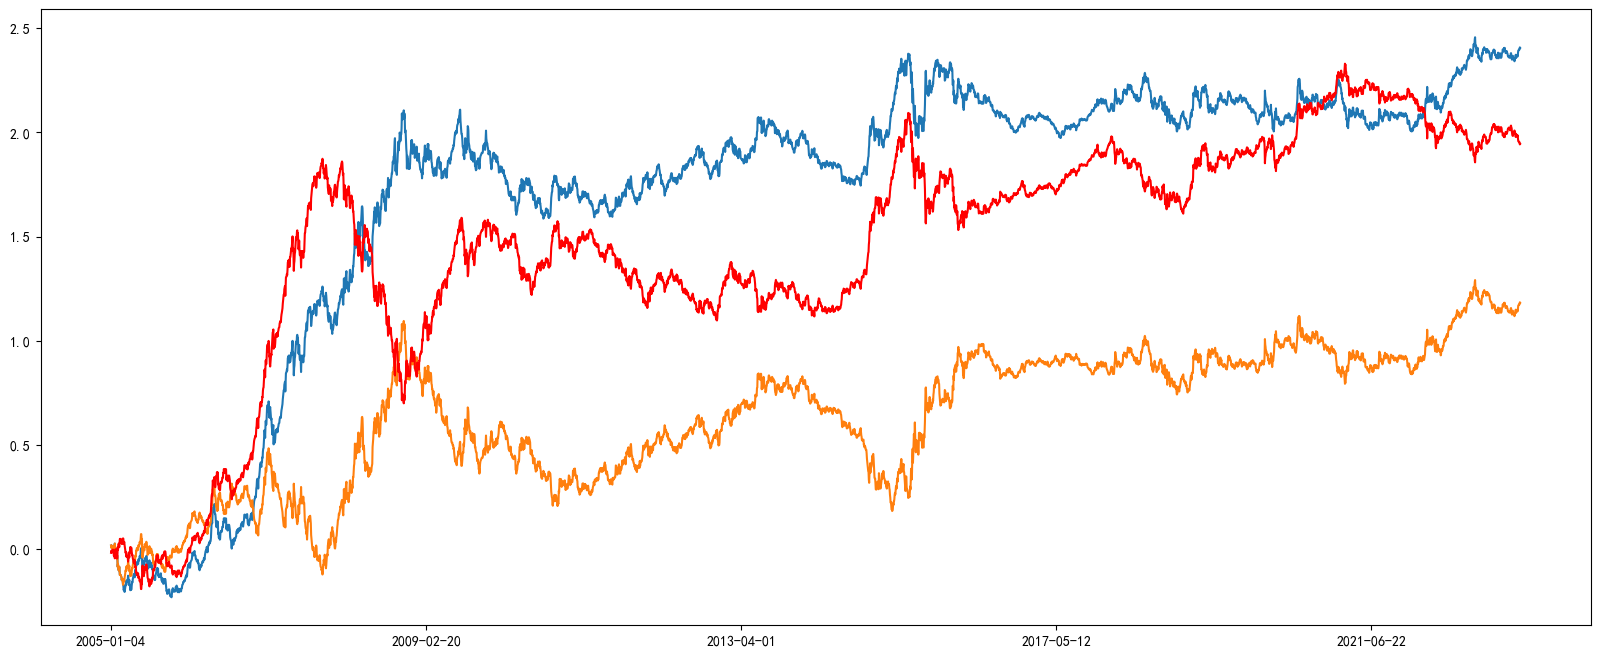

In [1064]:
(pd.Series((Except*ss_sigh)).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc[:].cumsum().plot(figsize=(20,8))
(pd.Series((ss_sigh)).shift(1) * xy.cl.loc['300',:].pct_change()).dropna().loc[:].cumsum().plot(figsize=(20,8))
(xy.cl.loc['300',:].pct_change().dropna().cumsum()).plot(color='red',figsize=(20,8))

-0.03474285714285715

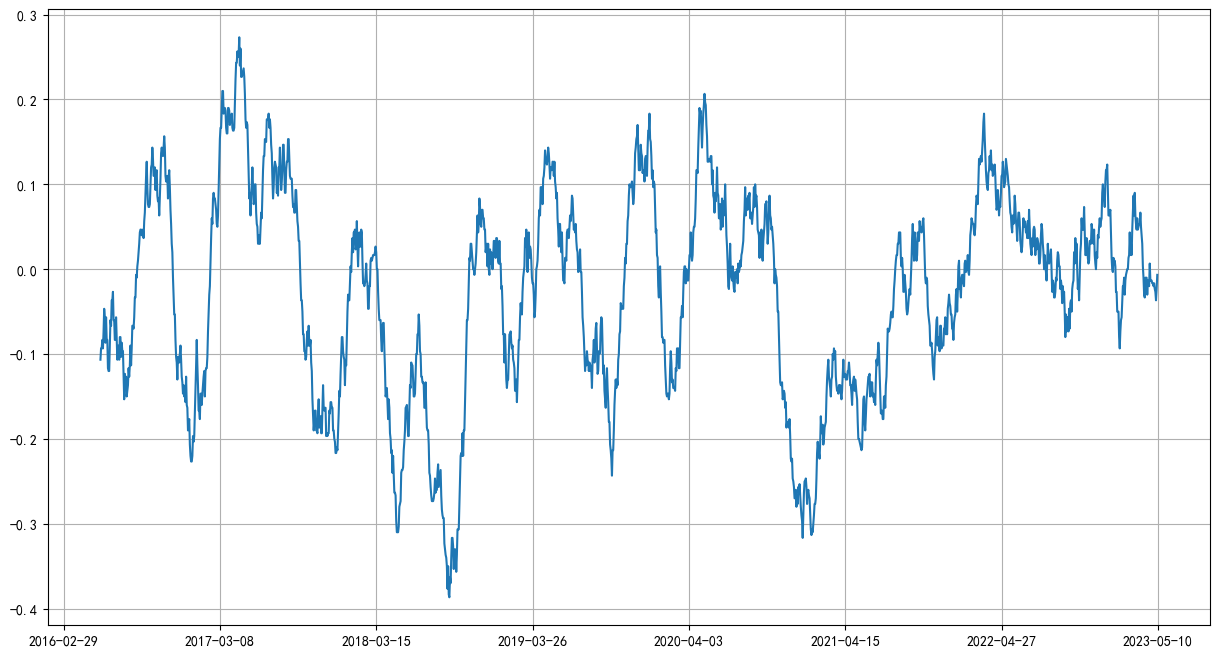

In [526]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()